## **Virus Classification**

+ **Datasets**: chest-xray-pneumonia + covidx-cxr2

+ **Classes**: Normal, Pneumonia, Covid_19

+ **Models**: GoogLeNet, DenseNet121

In [1]:
import os
import cv2
import platform
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output

os.environ['PYTHONHASHSEED'] = '73'

seed = 73
random.seed(seed)
np.random.seed(seed)

print(platform.platform())
%matplotlib inline

Windows-10-10.0.19043-SP0


In [2]:
three_classes_covid_xray_balanced = "/Users/MCSP_Lab/Desktop/covidx-dataset/covidx-cxr2/datasets/covid_cxr_dataset/train_covidx9a_9449/train"

In [3]:
print('> train_covidx9a_balance_5555 dir:', os.listdir(three_classes_covid_xray_balanced))

> train_covidx9a_balance_5555 dir: ['covid-19', 'normal', 'pneumonia']


## **Data Preparation**

In [4]:
from tqdm import tqdm

train_image_dir = three_classes_covid_xray_balanced 
#test_image_dir = three_classes_covid_xray_balanced + 
#val_image_dir = three_classes_covid_xray_balanced 

img_map = []

def prepareData(Dir, strat):
    cats = ["normal","pneumonia", "covid-19"]
    for category in cats:
        path = os.path.join(Dir,category)
        class_num = cats.index(category)
        
        for img in tqdm(os.listdir(path)):
            img_path = os.path.join(path,img)
            img_map.append({'path': img_path, 'label': category})

prepareData(train_image_dir,'train')
#prepareData(test_image_dir,'test')
#prepareData(val_image_dir, 'val')

img_map_covidx9a = pd.DataFrame(img_map).sample(frac = 1, random_state=seed)

100%|██████████| 9484/9484 [00:00<00:00, 364809.05it/s]


In [5]:
img_map_covidx9a.head()

path      label
6129   /Users/MCSP_Lab/Desktop/covidx-dataset/covidx-...     normal
7917   /Users/MCSP_Lab/Desktop/covidx-dataset/covidx-...     normal
13946  /Users/MCSP_Lab/Desktop/covidx-dataset/covidx-...  pneumonia
19830  /Users/MCSP_Lab/Desktop/covidx-dataset/covidx-...   covid-19
5445   /Users/MCSP_Lab/Desktop/covidx-dataset/covidx-...     normal

### **Getting image path and labels from *.txt files**

### **Visualization**

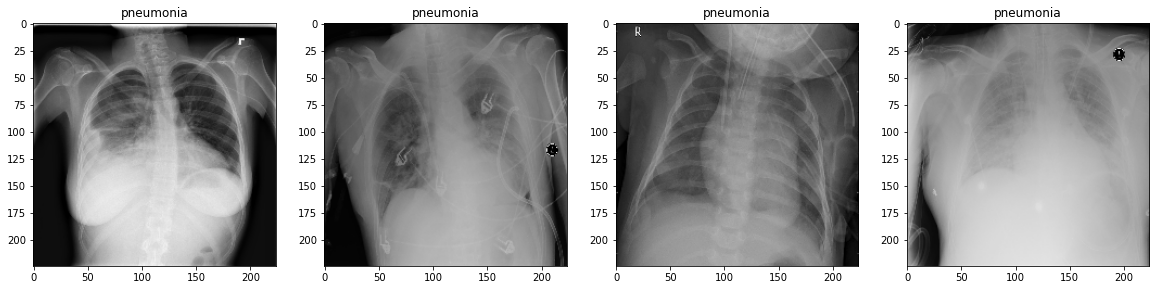

<Figure size 1440x576 with 0 Axes>

In [6]:
import matplotlib.pyplot as plt

def print_images(samples): 
    images = samples["path"].to_numpy()
    labels = samples['label'].to_numpy()
    
    fig=plt.figure(figsize=(20, 8))
    columns = 4
    rows = 1
    
    for i, image_path in enumerate(images):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        
        fig.add_subplot(rows,columns,i + 1)
        title = '{}'.format(labels[i])
        
        Sample_image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_CUBIC)
        
        plt.imshow(Sample_image, cmap='gray')
        plt.title(title)
        
    plt.show()
        
print_images(img_map_covidx9a[img_map_covidx9a['label']=="normal"].iloc[0:4])
print_images(img_map_covidx9a[img_map_covidx9a['label']=="pneumonia"].iloc[0:4])
print_images(img_map_covidx9a[img_map_covidx9a['label']=="COVID-19"].iloc[0:4])

%matplotlib inline

In [7]:
def getLabelCount(frame):
    label_count = pd.Series(frame['label'].values.ravel()).value_counts()
    n_classes = (label_count)
    return label_count

label_count = getLabelCount(img_map_covidx9a)
print(label_count)

pneumonia    9828
normal       9668
covid-19     9484
dtype: int64


In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

features = img_map_covidx9a['path'].to_numpy()
labels = img_map_covidx9a['label'].to_numpy()

stratified_sample = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=73)

In [9]:
for train_index, val_index in stratified_sample.split(features, labels):
    X_train, val_X = features[train_index], features[val_index]
    y_train, val_y = labels[train_index], labels[val_index]
    
half_size = np.int(len(val_X))
X_val, y_val = val_X[0:half_size], val_y[0:half_size]
#X_val, y_val = val_X[half_size:], val_y[half_size:]

C:\Users\MCSP_Lab\AppData\Local\Temp/ipykernel_9608/2292216186.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  half_size = np.int(len(val_X))


In [10]:
train_map = pd.DataFrame()
train_map['path'], train_map['label'] = X_train, y_train

In [11]:
val_map = pd.DataFrame()
val_map['path'], val_map['label'] = X_val, y_val

In [12]:
# data summary
print('> {} train size'.format(X_train.shape[0]))
print('> {} val size'.format(X_val.shape[0]))
#print('> {} val size'.format(X_val.shape[0]))

> 23184 train size
> 5796 val size


In [13]:
train_map.head()

path      label
0  /Users/MCSP_Lab/Desktop/covidx-dataset/covidx-...   covid-19
1  /Users/MCSP_Lab/Desktop/covidx-dataset/covidx-...   covid-19
2  /Users/MCSP_Lab/Desktop/covidx-dataset/covidx-...     normal
3  /Users/MCSP_Lab/Desktop/covidx-dataset/covidx-...     normal
4  /Users/MCSP_Lab/Desktop/covidx-dataset/covidx-...  pneumonia

In [14]:
import cv2
import time
import imageio
import imgaug.augmenters as iaa
import imgaug as ia
ia.seed(73)

ColorCh = 3
#IMG_SIZE = 224
IMG_SIZE = 224
input_shape=(IMG_SIZE, IMG_SIZE, ColorCh)

classes = ("COVID", "NORMAL","PNEUMONIA")
CATEGORIES = sorted(classes)

print('> Classes:',CATEGORIES)

> Classes: ['COVID', 'NORMAL', 'PNEUMONIA']


In [15]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

datagen = ImageDataGenerator(rescale = 1./255, 
                             horizontal_flip=True,
                             brightness_range=[1.0,1.3],
                             rotation_range=15,
                             #zoom_range=0.2
                            )

In [16]:
batch_size = 8

def get_generator(frame_):
    generator = datagen.flow_from_dataframe(
                          dataframe=frame_,
                          x_col="path",
                          y_col="label",
                          batch_size=batch_size,
                          seed=seed,
                          shuffle=False,
                          class_mode="sparse",
                          color_mode="rgb",
                          save_format="jpeg",
                          target_size=(IMG_SIZE,IMG_SIZE)             
             )
    
    return generator

In [17]:
train_df = train_map.sample(frac=1, random_state=seed)
train_generator = get_generator(train_df)

print('> label count for train set')
getLabelCount(train_df)

Found 23184 validated image filenames belonging to 3 classes.
> label count for train set


pneumonia    7862
normal       7735
covid-19     7587
dtype: int64

In [18]:
val_df = val_map.sample(frac=1, random_state=seed)
val_generator = get_generator(val_df)

print('> label count for val set')
getLabelCount(val_df)

Found 5796 validated image filenames belonging to 3 classes.
> label count for val set


pneumonia    1966
normal       1933
covid-19     1897
dtype: int64

In [19]:
print('> input shape:', input_shape)

> input shape: (224, 224, 3)


## **Building Models**

In [20]:
import keras
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Add, add
from tensorflow.keras.layers import InputLayer, Input, Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Activation, MaxPool2D, ZeroPadding2D, SeparableConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model, Sequential
from keras import regularizers

kernel_regularizer = regularizers.l2(0.0001)

final_activation = 'softmax'
entropy = 'sparse_categorical_crossentropy'
n_classes = len(CATEGORIES)
print('> {} classes'.format(n_classes))

> 3 classes


In [21]:
def FCLayers(baseModel):
    baseModel.trainable = True
    headModel = baseModel.output
    headModel = Dropout(0.5, seed=73)(headModel)
    headModel = Dense(n_classes, activation=final_activation)(headModel)
    
    model = Model(inputs = baseModel.input, outputs = headModel)
    return model

## **GoogLenet**

**Blog Reference**: https://medium.com/mlearning-ai/implementation-of-googlenet-on-keras-d9873aeed83c

In [30]:
from keras.layers.merge import concatenate

def Inception_block(input_layer, f1, f2, f3, f4):    
    
    path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
    
    path2 = Conv2D(filters = f2[0], kernel_size = (1,1), 
                   padding = 'same', activation = 'relu')(input_layer)
    
    path2 = Conv2D(filters = f2[1], kernel_size = (3,3), 
                   padding = 'same', activation = 'relu')(path2)

    path3 = Conv2D(filters = f3[0], kernel_size = (1,1), 
                   padding = 'same', activation = 'relu')(input_layer)
    
    path3 = Conv2D(filters = f3[1], kernel_size = (5,5), 
                   padding = 'same', activation = 'relu')(path3)

    path4 = MaxPooling2D((3,3), strides= (1,1), 
                         padding = 'same')(input_layer)
    
    path4 = Conv2D(filters = f4, kernel_size = (1,1), 
                   padding = 'same', activation = 'relu')(path4)
    
    output_layer = concatenate([path1, path2, path3, path4], axis = -1)

    return output_layer

In [71]:
# auxiliary_classifiers
def Extra_network_2(X):
    X2 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
    X2 = Conv2D(filters = 128, kernel_size = (1,1), 
                padding = 'same', activation = 'relu')(X2)
    
    X2 = Flatten()(X2)
    X2 = Dense(1024, activation = 'relu')(X2)
    X2 = Dropout(0.5)(X2)
    X2 = Dense(n_classes, activation = final_activation, name="output2")(X2)
    return X2


def Extra_network_1(X):
    X1 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
    X1 = Conv2D(filters = 128, kernel_size = (1,1), 
                padding = 'same', activation = 'relu')(X1)
    
    X1 = Flatten()(X1)
    X1 = Dense(1024, activation = 'relu')(X1)
    X1 = Dropout(0.5)(X1)
    X1 = Dense(n_classes, activation = final_activation, name="output1")(X1)
    return X1

In [72]:
def layer_4(X):
    X = Inception_block(X, 192, (96, 208) , (16, 48), 64)
    
    X1 = Extra_network_1(X)
    
    X = Inception_block(X, 160, (112, 224), (24, 64), 64)
    X = Inception_block(X, 128, (128, 256), (24, 64), 64)
    X = Inception_block(X, 112, (144, 288), (32, 64), 64)
    
    X2 = Extra_network_2(X)
    
    X = Inception_block(X, 256, (160, 320), (32, 128), 128)
    X = MaxPooling2D(pool_size = 3, strides = 2)(X)
    
    return X, X1, X2

def layer_3(X):
    X = Inception_block(X, 64, (96, 128), (16, 32), 32)
    X = Inception_block(X, 128, (128, 192), (32, 96), 64)
    X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)
    
    return X

def layer_2(X):
    X = Conv2D(filters = 64, 
               kernel_size = 1, 
               strides = 1, 
               padding = 'same', 
               activation = 'relu')(X)
    
    X = Conv2D(filters = 192, 
               kernel_size = 3, 
               padding = 'same', 
               activation = 'relu')(X)
    
    X = MaxPooling2D(pool_size= 3, strides = 2)(X)
    
    return X

In [73]:
def load_GoogLeNet():
    input_layer = Input(shape = input_shape)
    
    X = Conv2D(64, kernel_size = 7, strides = 2, 
               padding = 'valid', activation = 'relu')(input_layer)
    
    X = MaxPooling2D(pool_size = 3, strides = 2)(X)
    
    X = layer_2(X)
    X = layer_3(X)
    X, X1, X2 = layer_4(X)

    X = Inception_block(X, 256, (160, 320), (32, 128), 128)
    X = Inception_block(X, 384, (192, 384), (48, 128), 128)

    X = GlobalAveragePooling2D()(X)
    X = Dropout(0.6)(X)
    
    X = Dense(n_classes, activation = final_activation, name="output3")(X)
  
    model = Model(input_layer, [X, X1, X2], name = 'GoogLeNet')

    return model

load_GoogLeNet().summary()

Model: "GoogLeNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 384, 384, 3) 0                                            
__________________________________________________________________________________________________
conv2d_262 (Conv2D)             (None, 189, 189, 64) 9472        input_13[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_17 (MaxPooling2D) (None, 94, 94, 64)   0           conv2d_262[0][0]                 
__________________________________________________________________________________________________
conv2d_263 (Conv2D)             (None, 94, 94, 64)   4160        max_pooling2d_17[0][0]           
__________________________________________________________________________________________

## **DenseNet121**

In [105]:
from tensorflow.keras.applications import DenseNet121

def load_DenseNet121():
    input_tensor = Input(shape=input_shape)
    baseModel = DenseNet121(pooling='avg',
                            include_top=False, 
                            input_tensor=input_tensor)
    
    model = FCLayers(baseModel)
    return model

load_DenseNet121().summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 384, 384, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_10 (ZeroPadding2 (None, 390, 390, 3)  0           input_21[0][0]                   
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 192, 192, 64) 9408        zero_padding2d_10[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 192, 192, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

## Github Tensorflow Swin Transformer Model (rishigami)

In [22]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Conv2D, LayerNormalization, GlobalAveragePooling1D

CFGS = {
    'swin_tiny_224': dict(input_size=(224, 224), window_size=7, embed_dim=96, depths=[2, 2, 6, 2], num_heads=[3, 6, 12, 24]),
    'swin_small_224': dict(input_size=(224, 224), window_size=7, embed_dim=96, depths=[2, 2, 18, 2], num_heads=[3, 6, 12, 24]),
    'swin_base_224': dict(input_size=(224, 224), window_size=7, embed_dim=128, depths=[2, 2, 18, 2], num_heads=[4, 8, 16, 32]),
    'swin_base_384': dict(input_size=(384, 384), window_size=12, embed_dim=128, depths=[2, 2, 18, 2], num_heads=[4, 8, 16, 32]),
    'swin_large_224': dict(input_size=(224, 224), window_size=7, embed_dim=192, depths=[2, 2, 18, 2], num_heads=[6, 12, 24, 48]),
    'swin_large_384': dict(input_size=(384, 384), window_size=12, embed_dim=192, depths=[2, 2, 18, 2], num_heads=[6, 12, 24, 48])
}


class Mlp(tf.keras.layers.Layer):
    def __init__(self, in_features, hidden_features=None, out_features=None, drop=0., prefix=''):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = Dense(hidden_features, name=f'{prefix}/mlp/fc1')
        self.fc2 = Dense(out_features, name=f'{prefix}/mlp/fc2')
        self.drop = Dropout(drop)

    def call(self, x):
        x = self.fc1(x)
        x = tf.keras.activations.gelu(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


def window_partition(x, window_size):
    B, H, W, C = x.get_shape().as_list()
    x = tf.reshape(x, shape=[-1, H // window_size,
                   window_size, W // window_size, window_size, C])
    x = tf.transpose(x, perm=[0, 1, 3, 2, 4, 5])
    windows = tf.reshape(x, shape=[-1, window_size, window_size, C])
    return windows


def window_reverse(windows, window_size, H, W, C):
    x = tf.reshape(windows, shape=[-1, H // window_size,
                   W // window_size, window_size, window_size, C])
    x = tf.transpose(x, perm=[0, 1, 3, 2, 4, 5])
    x = tf.reshape(x, shape=[-1, H, W, C])
    return x


class WindowAttention(tf.keras.layers.Layer):
    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0., prefix=''):
        super().__init__()
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5
        self.prefix = prefix

        self.qkv = Dense(dim * 3, use_bias=qkv_bias,
                         name=f'{self.prefix}/attn/qkv')
        self.attn_drop = Dropout(attn_drop)
        self.proj = Dense(dim, name=f'{self.prefix}/attn/proj')
        self.proj_drop = Dropout(proj_drop)

    def build(self, input_shape):
        self.relative_position_bias_table = self.add_weight(f'{self.prefix}/attn/relative_position_bias_table',
                                                            shape=(
                                                                (2 * self.window_size[0] - 1) * (2 * self.window_size[1] - 1), self.num_heads),
                                                            initializer=tf.initializers.Zeros(), trainable=True)

        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords = np.stack(np.meshgrid(coords_h, coords_w, indexing='ij'))
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :,
                                         None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose([1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1).astype(np.int64)
        self.relative_position_index = tf.Variable(initial_value=tf.convert_to_tensor(
            relative_position_index), trainable=False, name=f'{self.prefix}/attn/relative_position_index')
        self.built = True

    def call(self, x, mask=None):
        B_, N, C = x.get_shape().as_list()
        qkv = tf.transpose(tf.reshape(self.qkv(
            x), shape=[-1, N, 3, self.num_heads, C // self.num_heads]), perm=[2, 0, 3, 1, 4])
        q, k, v = qkv[0], qkv[1], qkv[2]

        q = q * self.scale
        attn = (q @ tf.transpose(k, perm=[0, 1, 3, 2]))
        relative_position_bias = tf.gather(self.relative_position_bias_table, tf.reshape(
            self.relative_position_index, shape=[-1]))
        relative_position_bias = tf.reshape(relative_position_bias, shape=[
                                            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1])
        relative_position_bias = tf.transpose(
            relative_position_bias, perm=[2, 0, 1])
        attn = attn + tf.expand_dims(relative_position_bias, axis=0)

        if mask is not None:
            nW = mask.get_shape()[0]  # tf.shape(mask)[0]
            attn = tf.reshape(attn, shape=[-1, nW, self.num_heads, N, N]) + tf.cast(
                tf.expand_dims(tf.expand_dims(mask, axis=1), axis=0), tf.float32)
            attn = tf.reshape(attn, shape=[-1, self.num_heads, N, N])
            attn = tf.nn.softmax(attn, axis=-1)
        else:
            attn = tf.nn.softmax(attn, axis=-1)

        attn = self.attn_drop(attn)

        x = tf.transpose((attn @ v), perm=[0, 2, 1, 3])
        x = tf.reshape(x, shape=[-1, N, C])
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


def drop_path(inputs, drop_prob, is_training):
    if (not is_training) or (drop_prob == 0.):
        return inputs

    # Compute keep_prob
    keep_prob = 1.0 - drop_prob

    # Compute drop_connect tensor
    random_tensor = keep_prob
    shape = (tf.shape(inputs)[0],) + (1,) * \
        (len(tf.shape(inputs)) - 1)
    random_tensor += tf.random.uniform(shape, dtype=inputs.dtype)
    binary_tensor = tf.floor(random_tensor)
    output = tf.math.divide(inputs, keep_prob) * binary_tensor
    return output


class DropPath(tf.keras.layers.Layer):
    def __init__(self, drop_prob=None):
        super().__init__()
        self.drop_prob = drop_prob

    def call(self, x, training=None):
        return drop_path(x, self.drop_prob, training)


class SwinTransformerBlock(tf.keras.layers.Layer):
    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0, mlp_ratio=4.,
                 qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path_prob=0., norm_layer=LayerNormalization, prefix=''):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"
        self.prefix = prefix

        self.norm1 = norm_layer(epsilon=1e-5, name=f'{self.prefix}/norm1')
        self.attn = WindowAttention(dim, window_size=(self.window_size, self.window_size), num_heads=num_heads,
                                    qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop, prefix=self.prefix)
        self.drop_path = DropPath(
            drop_path_prob if drop_path_prob > 0. else 0.)
        self.norm2 = norm_layer(epsilon=1e-5, name=f'{self.prefix}/norm2')
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim,
                       drop=drop, prefix=self.prefix)

    def build(self, input_shape):
        if self.shift_size > 0:
            H, W = self.input_resolution
            img_mask = np.zeros([1, H, W, 1])
            h_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            w_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1

            img_mask = tf.convert_to_tensor(img_mask)
            mask_windows = window_partition(img_mask, self.window_size)
            mask_windows = tf.reshape(
                mask_windows, shape=[-1, self.window_size * self.window_size])
            attn_mask = tf.expand_dims(
                mask_windows, axis=1) - tf.expand_dims(mask_windows, axis=2)
            attn_mask = tf.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = tf.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = tf.Variable(
                initial_value=attn_mask, trainable=False, name=f'{self.prefix}/attn_mask')
        else:
            self.attn_mask = None

        self.built = True

    def call(self, x):
        H, W = self.input_resolution
        B, L, C = x.get_shape().as_list()
        assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = tf.reshape(x, shape=[-1, H, W, C])

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = tf.roll(
                x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2])
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = tf.reshape(
            x_windows, shape=[-1, self.window_size * self.window_size, C])

        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        # merge windows
        attn_windows = tf.reshape(
            attn_windows, shape=[-1, self.window_size, self.window_size, C])
        shifted_x = window_reverse(attn_windows, self.window_size, H, W, C)

        # reverse cyclic shift
        if self.shift_size > 0:
            x = tf.roll(shifted_x, shift=[
                        self.shift_size, self.shift_size], axis=[1, 2])
        else:
            x = shifted_x
        x = tf.reshape(x, shape=[-1, H * W, C])

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x


class PatchMerging(tf.keras.layers.Layer):
    def __init__(self, input_resolution, dim, norm_layer=LayerNormalization, prefix=''):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = Dense(2 * dim, use_bias=False,
                               name=f'{prefix}/downsample/reduction')
        self.norm = norm_layer(epsilon=1e-5, name=f'{prefix}/downsample/norm')

    def call(self, x):
        H, W = self.input_resolution
        B, L, C = x.get_shape().as_list()
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."

        x = tf.reshape(x, shape=[-1, H, W, C])

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = tf.concat([x0, x1, x2, x3], axis=-1)
        x = tf.reshape(x, shape=[-1, (H // 2) * (W // 2), 4 * C])

        x = self.norm(x)
        x = self.reduction(x)

        return x


class BasicLayer(tf.keras.layers.Layer):
    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path_prob=0., norm_layer=LayerNormalization, downsample=None, use_checkpoint=False, prefix=''):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = tf.keras.Sequential([SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                           num_heads=num_heads, window_size=window_size,
                                           shift_size=0 if (
                                               i % 2 == 0) else window_size // 2,
                                           mlp_ratio=mlp_ratio,
                                           qkv_bias=qkv_bias, qk_scale=qk_scale,
                                           drop=drop, attn_drop=attn_drop,
                                           drop_path_prob=drop_path_prob[i] if isinstance(
                                               drop_path_prob, list) else drop_path_prob,
                                           norm_layer=norm_layer,
                                           prefix=f'{prefix}/blocks{i}') for i in range(depth)])
        if downsample is not None:
            self.downsample = downsample(
                input_resolution, dim=dim, norm_layer=norm_layer, prefix=prefix)
        else:
            self.downsample = None

    def call(self, x):
        x = self.blocks(x)

        if self.downsample is not None:
            x = self.downsample(x)
        return x


class PatchEmbed(tf.keras.layers.Layer):
    def __init__(self, img_size=(224, 224), patch_size=(4, 4), in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__(name='patch_embed')
        patches_resolution = [img_size[0] //
                              patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        self.proj = Conv2D(embed_dim, kernel_size=patch_size,
                           strides=patch_size, name='proj')
        if norm_layer is not None:
            self.norm = norm_layer(epsilon=1e-5, name='norm')
        else:
            self.norm = None

    def call(self, x):
        B, H, W, C = x.get_shape().as_list()
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x)
        x = tf.reshape(
            x, shape=[-1, (H // self.patch_size[0]) * (W // self.patch_size[0]), self.embed_dim])
        if self.norm is not None:
            x = self.norm(x)
        return x


class SwinTransformerModel(tf.keras.Model):
    def __init__(self, model_name='swin_tiny_patch4_window7_224', include_top=False,
                 img_size=(224, 224), patch_size=(4, 4), in_chans=3, num_classes=1000,
                 embed_dim=96, depths=[2, 2, 6, 2], num_heads=[3, 6, 12, 24],
                 window_size=7, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=LayerNormalization, ape=False, patch_norm=True,
                 use_checkpoint=False, **kwargs):
        super().__init__(name=model_name)

        self.include_top = include_top

        self.num_classes = num_classes
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))
        self.mlp_ratio = mlp_ratio

        # split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        # absolute postion embedding
        if self.ape:
            self.absolute_pos_embed = self.add_weight('absolute_pos_embed',
                                                      shape=(
                                                          1, num_patches, embed_dim),
                                                      initializer=tf.initializers.Zeros())

        self.pos_drop = Dropout(drop_rate)

        # stochastic depth
        dpr = [x for x in np.linspace(0., drop_path_rate, sum(depths))]

        # build layers
        self.basic_layers = tf.keras.Sequential([BasicLayer(dim=int(embed_dim * 2 ** i_layer),
                                                input_resolution=(patches_resolution[0] // (2 ** i_layer),
                                                                  patches_resolution[1] // (2 ** i_layer)),
                                                depth=depths[i_layer],
                                                num_heads=num_heads[i_layer],
                                                window_size=window_size,
                                                mlp_ratio=self.mlp_ratio,
                                                qkv_bias=qkv_bias, qk_scale=qk_scale,
                                                drop=drop_rate, attn_drop=attn_drop_rate,
                                                drop_path_prob=dpr[sum(depths[:i_layer]):sum(
                                                    depths[:i_layer + 1])],
                                                norm_layer=norm_layer,
                                                downsample=PatchMerging if (
                                                    i_layer < self.num_layers - 1) else None,
                                                use_checkpoint=use_checkpoint,
                                                prefix=f'layers{i_layer}') for i_layer in range(self.num_layers)])
        self.norm = norm_layer(epsilon=1e-5, name='norm')
        self.avgpool = GlobalAveragePooling1D()
        if self.include_top:
            self.head = Dense(num_classes, name='head')
        else:
            self.head = None

    def forward_features(self, x):
        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)

        x = self.basic_layers(x)
        x = self.norm(x)
        x = self.avgpool(x)
        return x

    def call(self, x):
        x = self.forward_features(x)
        if self.include_top:
            x = self.head(x)
        return x


def SwinTransformer(model_name='swin_tiny_224', num_classes=1000, include_top=True, pretrained=True, use_tpu=False, cfgs=CFGS):
    cfg = cfgs[model_name]
    net = SwinTransformerModel(
        model_name=model_name, include_top=include_top, num_classes=num_classes, img_size=cfg['input_size'], window_size=cfg[
            'window_size'], embed_dim=cfg['embed_dim'], depths=cfg['depths'], num_heads=cfg['num_heads']
    )
    net(tf.keras.Input(shape=(cfg['input_size'][0], cfg['input_size'][1], 3)))
    if pretrained is True:
        url = f'https://github.com/rishigami/Swin-Transformer-TF/releases/download/v0.1-tf-swin-weights/{model_name}.tgz'
        pretrained_ckpt = tf.keras.utils.get_file(
            model_name, url, untar=True)
    else:
        pretrained_ckpt = pretrained

    if pretrained_ckpt:
        if tf.io.gfile.isdir(pretrained_ckpt):
            pretrained_ckpt = f'{pretrained_ckpt}/{model_name}.ckpt'

        if use_tpu:
            load_locally = tf.saved_model.LoadOptions(
                experimental_io_device='/job:localhost')
            net.load_weights(pretrained_ckpt, options=load_locally)
        else:
            net.load_weights(pretrained_ckpt)

    return net

In [23]:
IMAGE_SIZE=[224, 224]
CLASSES = ['normal', 'other_pneumonia', 'covid-19']

def load_swin_transformer():
    img_adjust_layer = tf.keras.layers.Lambda(lambda data: tf.keras.applications.imagenet_utils.preprocess_input(tf.cast(data, tf.float32), mode="torch"), input_shape=[*IMAGE_SIZE, 3])
    pretrained_model = SwinTransformer('swin_base_224', num_classes=len(CLASSES), include_top=False, pretrained=True, use_tpu=True)
    model = tf.keras.Sequential([
        img_adjust_layer,
        pretrained_model,
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
    return model

load_swin_transformer().summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 224, 224, 3)       0         
_________________________________________________________________
swin_base_224 (SwinTransform (None, 1024)              87079364  
_________________________________________________________________
dense (Dense)                (None, 3)                 3075      
Total params: 87,082,439
Trainable params: 86,746,299
Non-trainable params: 336,140
_________________________________________________________________


# Hybrid-Trans

In [63]:
import os, random, cv2
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import tensorflow.keras.backend as K 
import tensorflow as tf; print(tf.__version__)
from tensorflow.keras import layers 
from tensorflow import keras

import matplotlib.pyplot as plt
from numpy.random import rand 
import matplotlib.cm as cm
import numpy as np 

physical_devices = tf.config.list_physical_devices('GPU')
try: 
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    tf.config.optimizer.set_jit(True)
except: 
    pass 

seed = 786
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

2.6.0


In [64]:
patch_size      = (2,2)  # 4-by-4 sized patches
dropout_rate    = 0.5     # Dropout rate
num_heads       = 8       # Attention heads
embed_dim       = 64      # Embedding dimension
num_mlp         = 128     # MLP layer size
qkv_bias        = True    # Convert embedded patches to query, key, and values with a learnable additive value
window_size     = 2       # Size of attention window
shift_size      = 1       # Size of shifting window
image_dimension = 24      # Initial image size / Input size of the transformer model 

num_patch_x = image_dimension // patch_size[0]
num_patch_y = image_dimension // patch_size[1]

img_size = 384
class_number = 3

In [65]:
def window_partition(x, window_size):
    _, height, width, channels = x.shape
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        x, shape=(-1, patch_num_y, window_size, patch_num_x, window_size, channels)
    )
    x = tf.transpose(x, (0, 1, 3, 2, 4, 5))
    windows = tf.reshape(x, shape=(-1, window_size, window_size, channels))
    return windows


def window_reverse(windows, window_size, height, width, channels):
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        windows,
        shape=(-1, patch_num_y, patch_num_x, window_size, window_size, channels),
    )
    x = tf.transpose(x, perm=(0, 1, 3, 2, 4, 5))
    x = tf.reshape(x, shape=(-1, height, width, channels))
    return x


class DropPath(layers.Layer):
    def __init__(self, drop_prob=None, **kwargs):
        super(DropPath, self).__init__(**kwargs)
        self.drop_prob = drop_prob

    def call(self, x):
        input_shape = tf.shape(x)
        batch_size = input_shape[0]
        rank = x.shape.rank
        shape = (batch_size,) + (1,) * (rank - 1)
        random_tensor = (1 - self.drop_prob) + tf.random.uniform(shape, dtype=x.dtype)
        path_mask = tf.floor(random_tensor)
        output = tf.math.divide(x, 1 - self.drop_prob) * path_mask
        return output

In [66]:
class WindowAttention(layers.Layer):
    def __init__(
        self, dim, window_size, num_heads, qkv_bias=True, dropout_rate=0.0, **kwargs
    ):
        super(WindowAttention, self).__init__(**kwargs)
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5
        self.qkv = layers.Dense(dim * 3, use_bias=qkv_bias)
        self.dropout = layers.Dropout(dropout_rate)
        self.proj = layers.Dense(dim)

    def build(self, input_shape):
        num_window_elements = (2 * self.window_size[0] - 1) * (
            2 * self.window_size[1] - 1
        )
        self.relative_position_bias_table = self.add_weight(
            shape=(num_window_elements, self.num_heads),
            initializer=tf.initializers.Zeros(),
            trainable=True,
            name="Hybrid_Transformer"
        )
        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords_matrix = np.meshgrid(coords_h, coords_w, indexing="ij")
        coords = np.stack(coords_matrix)
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose([1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)

        self.relative_position_index = tf.Variable(
            initial_value=tf.convert_to_tensor(relative_position_index), trainable=False
        )

    def call(self, x, mask=None):
        _, size, channels = x.shape
        head_dim = channels // self.num_heads
        x_qkv = self.qkv(x)
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, 3, self.num_heads, head_dim))
        x_qkv = tf.transpose(x_qkv, perm=(2, 0, 3, 1, 4))
        q, k, v = x_qkv[0], x_qkv[1], x_qkv[2]
        q = q * self.scale
        k = tf.transpose(k, perm=(0, 1, 3, 2))
        attn = q @ k

        num_window_elements = self.window_size[0] * self.window_size[1]
        relative_position_index_flat = tf.reshape(
            self.relative_position_index, shape=(-1,)
        )
        relative_position_bias = tf.gather(
            self.relative_position_bias_table, relative_position_index_flat
        )
        relative_position_bias = tf.reshape(
            relative_position_bias, shape=(num_window_elements, num_window_elements, -1)
        )
        relative_position_bias = tf.transpose(relative_position_bias, perm=(2, 0, 1))
        attn = attn + tf.expand_dims(relative_position_bias, axis=0)

        if mask is not None:
            nW = mask.get_shape()[0]
            mask_float = tf.cast(
                tf.expand_dims(tf.expand_dims(mask, axis=1), axis=0), tf.float32
            )
            attn = (
                tf.reshape(attn, shape=(-1, nW, self.num_heads, size, size))
                + mask_float
            )
            attn = tf.reshape(attn, shape=(-1, self.num_heads, size, size))
            attn = keras.activations.softmax(attn, axis=-1)
        else:
            attn = keras.activations.softmax(attn, axis=-1)
        attn = self.dropout(attn)

        x_qkv = attn @ v
        x_qkv = tf.transpose(x_qkv, perm=(0, 2, 1, 3))
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, channels))
        x_qkv = self.proj(x_qkv)
        x_qkv = self.dropout(x_qkv)
        return x_qkv

In [67]:

class SwinTransformer(layers.Layer):
    def __init__(
        self, 
        dim,
        num_patch,
        num_heads,
        window_size=7,
        shift_size=0,
        num_mlp=1024,
        qkv_bias=True,
        dropout_rate=0.0,
        **kwargs,
    ):
        super(SwinTransformer, self).__init__(**kwargs)

        self.dim = dim  # number of input dimensions
        self.num_patch = num_patch  # number of embedded patches
        self.num_heads = num_heads  # number of attention heads
        self.window_size = window_size  # size of window
        self.shift_size = shift_size  # size of window shift
        self.num_mlp = num_mlp  # number of MLP nodes

        self.norm1 = layers.LayerNormalization(epsilon=1e-5)
        self.attn = WindowAttention(
            dim,
            window_size=(self.window_size, self.window_size),
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            dropout_rate=dropout_rate,
        )
        self.drop_path = DropPath(dropout_rate)
        self.norm2 = layers.LayerNormalization(epsilon=1e-5)

        self.mlp = keras.Sequential(
            [
                layers.Dense(num_mlp),
                layers.Activation(keras.activations.gelu),
                layers.Dropout(dropout_rate),
                layers.Dense(dim),
                layers.Dropout(dropout_rate),
            ]
        )

        if min(self.num_patch) < self.window_size:
            self.shift_size = 0
            self.window_size = min(self.num_patch)

    def build(self, input_shape):
        if self.shift_size == 0:
            self.attn_mask = None
        else:
            height, width = self.num_patch
            h_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            w_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            mask_array = np.zeros((1, height, width, 1))
            count = 0
            for h in h_slices:
                for w in w_slices:
                    mask_array[:, h, w, :] = count
                    count += 1
            mask_array = tf.convert_to_tensor(mask_array)

            # mask array to windows
            mask_windows = window_partition(mask_array, self.window_size)
            mask_windows = tf.reshape(
                mask_windows, shape=[-1, self.window_size * self.window_size]
            )
            attn_mask = tf.expand_dims(mask_windows, axis=1) - tf.expand_dims(
                mask_windows, axis=2
            )
            attn_mask = tf.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = tf.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = tf.Variable(initial_value=attn_mask, trainable=False)

    def call(self, x):
        height, width = self.num_patch
        _, num_patches_before, channels = x.shape
        x_skip = x
        x = self.norm1(x)
        x = tf.reshape(x, shape=(-1, height, width, channels))
        if self.shift_size > 0:
            shifted_x = tf.roll(
                x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2]
            )
        else:
            shifted_x = x

        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = tf.reshape(
            x_windows, shape=(-1, self.window_size * self.window_size, channels)
        )
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        attn_windows = tf.reshape(
            attn_windows, shape=(-1, self.window_size, self.window_size, channels)
        )
        shifted_x = window_reverse(
            attn_windows, self.window_size, height, width, channels
        )
        if self.shift_size > 0:
            x = tf.roll(
                shifted_x, shift=[self.shift_size, self.shift_size], axis=[1, 2]
            )
        else:
            x = shifted_x

        x = tf.reshape(x, shape=(-1, height * width, channels))
        x = self.drop_path(x)
        x = x_skip + x
        x_skip = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = self.drop_path(x)
        x = x_skip + x
        return x

In [68]:
class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super(PatchExtract, self).__init__(**kwargs)
        self.patch_size_x = patch_size[0]
        self.patch_size_y = patch_size[0]

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=(1, self.patch_size_x, self.patch_size_y, 1),
            strides=(1, self.patch_size_x, self.patch_size_y, 1),
            rates=(1, 1, 1, 1),
            padding="VALID",
        )
        patch_dim = patches.shape[-1]
        patch_num = patches.shape[1]
        return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super(PatchEmbedding, self).__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        return self.proj(patch) + self.pos_embed(pos)


class PatchMerging(tf.keras.layers.Layer):
    def __init__(self, num_patch, embed_dim):
        super(PatchMerging, self).__init__()
        self.num_patch = num_patch
        self.embed_dim = embed_dim
        self.linear_trans = layers.Dense(2 * embed_dim, use_bias=False)

    def call(self, x):
        height, width = self.num_patch
        _, _, C = x.get_shape().as_list()
        x = tf.reshape(x, shape=(-1, height, width, C))
        feat_maps = x
     
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = tf.concat((x0, x1, x2, x3), axis=-1)
        x = tf.reshape(x, shape=(-1, (height // 2) * (width // 2), 4 * C))
        return self.linear_trans(x), feat_maps

In [69]:
import numpy as np 
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import Model, Sequential, Input, layers, applications

In [75]:
BASE_WEIGHTS = '/Users/MCSP_Lab/Desktop/covidx-dataset/covidx-cxr2/models/efficientnet-keras-noisystudent-weights-b0b7/'

IMG_NET    = [
    'imagenet/imagenet.notop-b0.h5',
    'imagenet/imagenet.notop-b1.h5',
    'imagenet/imagenet.notop-b2.h5'
]

NOISY_STUD = [
    'noisystudent/noisy.student.notop-b0.h5',
    'noisystudent/noisy.student.notop-b1.h5',
    'noisystudent/noisy.student.notop-b2.h5',
]

ADV_PROB = [
    'advprob/adv.prop.notop-b0.h5',
    'advprob/adv.prop.notop-b1.h5',
    'advprob/adv.prop.notop-b2.h5'
]

In [76]:
class HybridSwinTransformer(keras.Model):
    def __init__(self):
        super(HybridSwinTransformer, self).__init__()
        # base models 
        self.inputx = keras.Input((img_size, img_size, 3), name='input_hybrids')
        base = applications.EfficientNetB0(
            include_top=False,
            weights=BASE_WEIGHTS + ADV_PROB[0],
            input_tensor=self.inputx
        )
        
        # base model with compatible output which will be an input of transformer model 
        self.new_base = keras.Model(
            [base.inputs], 
            [
                base.get_layer('block6a_expand_activation').output, 
                base.output
            ], # output with 192 feat_maps
            name='efficientnet'
        )
        
        # stuff of swin transformers 
        self.patch_extract  = PatchExtract(patch_size)
        self.patch_embedds  = PatchEmbedding(num_patch_x * num_patch_y, embed_dim)
        self.patch_merging  = PatchMerging((num_patch_x, num_patch_y), embed_dim=embed_dim)
        
        # swin blocks containers 
        self.swin_sequences = keras.Sequential(name='swin_blocks')
        for i in range(shift_size):
            self.swin_sequences.add(
                SwinTransformer(
                    dim=embed_dim,
                    num_patch=(num_patch_x, num_patch_y),
                    num_heads=num_heads,
                    window_size=window_size,
                    shift_size=i,
                    num_mlp=num_mlp,
                    qkv_bias=qkv_bias,
                    dropout_rate=dropout_rate
                )
            )
        
        # swin block's head
        self.swin_head = keras.Sequential(
            [
                layers.GlobalAveragePooling1D(),
                layers.AlphaDropout(0.5),
                layers.BatchNormalization(),
            ], name='swin_head'
        )
        
        # base model's (cnn model) head
        self.conv_head = keras.Sequential(
            [
                layers.GlobalAveragePooling2D(),
                layers.AlphaDropout(0.5),
            ], name='conv_head'
        )
        
        # classifier
        self.classifier = layers.Dense(class_number, dtype='float32')
        
        
    def call(self, inputs, training=None, **kwargs):
        x , base_gcam_top = self.new_base(inputs)
        x = self.patch_extract(x)
        x = self.patch_embedds(x)
        x = self.swin_sequences(x)
        x, swin_gcam_top = self.patch_merging(x)
        
        swin_top = self.swin_head(x)
        conv_top = self.conv_head(base_gcam_top)
        preds = self.classifier(tf.concat([swin_top, conv_top], axis=-1))
        
        if training: # training phase 
            return preds
        else: # inference phase
            return preds, base_gcam_top, swin_gcam_top

    def build_graph(self):
        x = keras.Input(shape=(img_size, img_size, 3))
        return keras.Model(inputs=[x], outputs=self.call(x))
    
keras.backend.clear_session()
model = HybridSwinTransformer()
print(model(tf.ones((2, img_size, img_size, 3)))[0].shape)
display(keras.utils.plot_model(model.build_graph(), 
                               show_shapes=True,
                               show_layer_names=True, 
                               expand_nested=False))
model.build_graph().summary()

(2, 3)
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


None

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 384, 384, 3) 0                                            
__________________________________________________________________________________________________
efficientnet (Functional)       [(None, 24, 24, 672) 4049571     input_2[0][0]                    
__________________________________________________________________________________________________
patch_extract (PatchExtract)    (None, 144, 2688)    0           efficientnet[1][0]               
__________________________________________________________________________________________________
patch_embedding (PatchEmbedding (None, 144, 64)      181312      patch_extract[1][0]              
____________________________________________________________________________________________

In [77]:
def load_hybrid_swin_transformer():
    model = HybridSwinTransformer()
    return model

## InceptionNet

In [141]:
class_count=3
model_name='InceptionResNetV2'
base_model=tf.keras.applications.InceptionResNetV2(include_top=False, weights="imagenet",input_shape=(384, 384, 3), pooling='max') 
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.3, seed=123)(x)        
output=Dense(class_count, activation='softmax')(x)

In [142]:
def load_inception_net():
    model = Model(inputs=base_model.input, outputs=output)
    return model

## DOLGNet

In [36]:
!git clone https://github.com/innat/DOLG-TensorFlow.git -q

fatal: destination path 'DOLG-TensorFlow' already exists and is not an empty directory.


In [37]:
import sys 
sys.path.insert(0, "DOLG-TensorFlow")

import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers

from layers.GeM import GeneralizedMeanPooling2D
from layers.LocalBranch import DOLGLocalBranch
from layers.OrtholFusion import OrthogonalFusion

In [38]:
base = keras.applications.EfficientNetB5(
            include_top=False,
            weights='imagenet',
            input_tensor=keras.Input((IMG_SIZE, IMG_SIZE, 3))
        )

new_base = keras.Model(
    [base.inputs], 
    [
        base.get_layer('block5g_add').output,  # fol local branch 
        base.get_layer('block7c_add').output   # for global branch 
        ], 
    name='EfficientNet'
)

In [39]:
class DOLGNet(keras.Model):
    def __init__(self, backbone=None, num_classes=1, activation=None, **kwargs):
        super(DOLGNet, self).__init__(name='DOLGNet', **kwargs)
        # Number of classes 
        self.num_classes = num_classes
        self.activation  = activation
        
        # Base blcoks 
        self.base = backbone
        self.base_input_shape  = self.base.input_shape[0][1]

        # Top building blocks 
        self.orthogonal_fusion = OrthogonalFusion()
        self.local_branch      = DOLGLocalBranch(IMG_SIZE=self.base_input_shape)
        
        # Tail blcok 1 
        self.glob_branch_pool = keras.Sequential(
            [
                GeneralizedMeanPooling2D(),
                layers.Dense(1024, activation=None)
            ], 
            name='GlobalBranchPooling'
        )
        
        # Head block
        self.classifier = keras.Sequential(
            [
                layers.GlobalAveragePooling2D(name='HeadGAP'),
                layers.Dense(self.num_classes, activation = self.activation)
            ], 
            name='Classifiers'
        )
       
    # forwarding the computation 
    def call(self, inputs, training=None, **kwargs):
        # Get tensor from target layers 
        to_local, to_global = self.base(inputs)

        # Pass the received tensor to Top building blocks 
        local_feat      = self.local_branch(to_local)
        global_feat     = self.glob_branch_pool(to_global)
        orthogonal_feat = self.orthogonal_fusion([local_feat, global_feat]) 
        return self.classifier(orthogonal_feat)

    def build_graph(self):
        x = keras.Input(shape=(self.base_input_shape, self.base_input_shape, 3))
        return keras.Model(inputs=[x], outputs=self.call(x))

In [40]:
dolg_net = DOLGNet(new_base, num_classes=3, activation='softmax')
dolg_net.build_graph().summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
EfficientNet (Functional)       [(None, 14, 14, 176) 27456759    input_4[0][0]                    
__________________________________________________________________________________________________
LocalBranch (DOLGLocalBranch)   (None, 7, 7, 1024)   5025024     EfficientNet[0][0]               
__________________________________________________________________________________________________
GlobalBranchPooling (Sequential (None, 1024)         525824      EfficientNet[0][1]               
______________________________________________________________________________________________

In [42]:
def load_DOLG_net():
    model = DOLGNet(new_base, num_classes=3, activation='softmax')
    return model

## Get metrics

In [24]:
def getMetrics(name, type_):
    if name == 'GoogLeNet':
        if type_ == 'accuracy':
            return 'output3_accuracy'
        if type_ == 'loss':
            return 'output3_loss'
        if type_ == 'val_accuracy':
            return 'val_output3_accuracy'
        if type_ == 'val_loss':
            return 'val_output3_loss'
        
    else:
        if type_ == 'accuracy':
            return 'accuracy'
        if type_ == 'loss':
            return 'loss'
        if type_ == 'val_accuracy':
            return 'val_accuracy'
        if type_ == 'val_loss':
            return 'val_loss'

## **Call Backs**

In [25]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau
          
EPOCHS = 120
patience = 10

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005

rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8
        
def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
        
def getCallbacks(name):
    class myCallback(Callback):
        def on_epoch_end(self, epoch, logs={}):
            if ((logs.get(getMetrics(name,'accuracy'))>=0.999)):
                print("\nLimits Reached cancelling training!")
                self.model.stop_training = True

            
    end_callback = myCallback()

    lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min')

    lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=False)

    early_stopping = EarlyStopping(patience = patience, monitor=getMetrics(name, 'val_loss'),
                                 mode='min', restore_best_weights=True, 
                                 verbose = 1, min_delta = .00075)


    checkpoint_filepath = name + '_Weights.h5'

    model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor=getMetrics(name, 'val_loss'),
                                        mode='min',
                                        verbose = 1,
                                        save_best_only=True)

    import datetime
    log_dir="logs/fit/" + '_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")  
    tensorboard_callback = TensorBoard(log_dir = log_dir, write_graph=True, histogram_freq=1)

    return [end_callback, 
             lr_callback, 
             model_checkpoints,
             early_stopping,
             #tensorboard_callback,
             lr_plat
            ]

GoogLeNet_callbacks = getCallbacks('GoogLeNet')
SwinTransformer_callbacks = getCallbacks('SwinTransformer')
callbacks = getCallbacks('DenseNet121')
Hybrid_callbacks = getCallbacks('HybridTransformer') 
InceptionNet_callbacks = getCallbacks('InceptionNet')
DOLG_callbacks = getCallbacks('DOLGNet')

## **Compile** and **Fit Model**

In [26]:
from tensorflow_addons import optimizers as tfa_optimizers

def CompileModel(name, model):
    if name == 'GoogLeNet':
        model.compile(optimizer='adam', loss=entropy, metrics={"output1":"accuracy", "output2":"accuracy", "output3":"accuracy"})
    #if name == 'InceptionNet':
    #    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 
    #if name == 'HybridTransformer':
     #   model.compile(optimizer=tfa_optimizers.AdamW(learning_rate=1e-4, weight_decay=0.00001), loss='categorical_crossentropy', metrics=['accuracy']) 
    else:
        model.compile(optimizer='adam', loss=entropy, metrics=["accuracy"])
    return model

def FitModel(model, name):
    callbacks_ = callbacks
    if name == 'SwinTransformer':
        callbacks_ = SwinTransformer_callbacks
    if name == 'GoogLeNet':
        callbacks_ = GoogLeNet_callbacks
    if name == 'HybridTransformer':
        callbacks_ = Hybrid_callbacks
    if name == 'InceptionNet':
        callbacks_ = InceptionNet_callbacks
    if name == 'DOLGNet':
        callbacks_ = DOLG_callbacks
    history = model.fit(train_generator, 
                        epochs=EPOCHS,
                        callbacks=callbacks_,
                        validation_data = val_generator,
                        steps_per_epoch=(len(train_generator.labels) / 80),
                        validation_steps=(len(val_generator.labels) / 80),
                       )
    
    model.load_weights(name + '_Weights.h5')

    final_accuracy_avg = np.mean(history.history[getMetrics(name, "val_accuracy")][-5:])

    final_loss = history.history[getMetrics(name, "val_loss")][-1]
  
    group = {history: 'history', name: 'name', model: 'model', final_accuracy_avg:'acc', final_loss: 'loss'}

    print('\n')
    print('---'*15)
    print(name,' Model')
    print('Total Epochs :', len(history.history[getMetrics(name, 'loss')]))    
    print('Restoring best Weights')
    
    index = (len(history.history[getMetrics(name, 'loss')]) - (patience + 1))
    print('---'*15)
    print('Best Epoch :', index)
    print('---'*15)
    
    train_accuracy = history.history[getMetrics(name, 'accuracy')][index]
    train_loss = history.history[getMetrics(name, 'loss')][index]
    
    val_accuracy = history.history[getMetrics(name, 'val_accuracy')][index]
    val_loss = history.history[getMetrics(name, 'val_loss')][index]

    print('Accuracy on train:', train_accuracy,
          '\tLoss on train:', train_loss)
    
    print('Accuracy on val:', val_accuracy ,
          '\tLoss on val:', val_loss)
    print('---'*15)

    return model, history

In [27]:
def BuildModel(name):
    if name == 'GoogLeNet':
        prepared_model = load_GoogLeNet() 
    if name == 'DenseNet121':
        prepared_model = load_DenseNet121()
    if name == 'SwinTransformer':
        prepared_model = load_swin_transformer()
    if name == 'HybridTransformer':
        prepared_model = load_hybrid_swin_transformer()
    if name == 'InceptionNet':
        prepared_model = load_inception_net()
    if name == 'DOLGNet':
        prepared_model = load_DOLG_net()
    compiled_model = CompileModel(name, prepared_model)
    return compiled_model

## Training InceptionNet

In [ ]:
i_compiled_model = BuildModel('InceptionNet')
i_model, i_history = FitModel(i_compiled_model, 'InceptionNet')

## Training Hybrid_Trans

In [ ]:
h_compiled_model = BuildModel('HybridTransformer')
h_model, h_history = FitModel(h_compiled_model, 'HybridTransformer')

## Training SwinTransformer

In [28]:
s_compiled_model = BuildModel('SwinTransformer')
s_model, s_history = FitModel(s_compiled_model, 'SwinTransformer')

Epoch 1/120
289/289 [==============================] - 142s 371ms/step - loss: 0.8948 - accuracy: 0.5767 - val_loss: 0.7941 - val_accuracy: 0.6644

Epoch 00001: val_loss improved from inf to 0.79409, saving model to SwinTransformer_Weights.h5
Epoch 2/120
289/289 [==============================] - 103s 355ms/step - loss: 0.6290 - accuracy: 0.7461 - val_loss: 0.5624 - val_accuracy: 0.7620

Epoch 00002: val_loss improved from 0.79409 to 0.56237, saving model to SwinTransformer_Weights.h5
Epoch 3/120
289/289 [==============================] - 104s 358ms/step - loss: 0.5393 - accuracy: 0.7806 - val_loss: 0.4422 - val_accuracy: 0.8271

Epoch 00003: val_loss improved from 0.56237 to 0.44218, saving model to SwinTransformer_Weights.h5
Epoch 4/120
289/289 [==============================] - 102s 352ms/step - loss: 0.4987 - accuracy: 0.8082 - val_loss: 0.4496 - val_accuracy: 0.8116

Epoch 00004: val_loss did not improve from 0.44218
Epoch 5/120
289/289 [==============================] - 102s 350m

## **Training GoogLeNet**

In [97]:
g_compiled_model = BuildModel('GoogLeNet')
g_model, g_history = FitModel(g_compiled_model, 'GoogLeNet')

Epoch 1/120
289/289 [==============================] - 233s 793ms/step - loss: 3.2549 - output3_loss: 1.0967 - output1_loss: 1.0780 - output2_loss: 1.0803 - output3_accuracy: 0.3446 - output1_accuracy: 0.4015 - output2_accuracy: 0.4164 - val_loss: 3.0869 - val_output3_loss: 1.0874 - val_output1_loss: 1.0152 - val_output2_loss: 0.9843 - val_output3_accuracy: 0.4692 - val_output1_accuracy: 0.5933 - val_output2_accuracy: 0.5873

Epoch 00001: val_output3_loss did not improve from 0.44661
Epoch 2/120
289/289 [==============================] - 234s 807ms/step - loss: 2.7282 - output3_loss: 0.9874 - output1_loss: 0.9005 - output2_loss: 0.8404 - output3_accuracy: 0.5203 - output1_accuracy: 0.6039 - output2_accuracy: 0.6377 - val_loss: 2.3154 - val_output3_loss: 0.8296 - val_output1_loss: 0.7670 - val_output2_loss: 0.7187 - val_output3_accuracy: 0.6104 - val_output1_accuracy: 0.6772 - val_output2_accuracy: 0.7046

Epoch 00002: val_output3_loss did not improve from 0.44661
Epoch 3/120
289/289 [=

## **Training DenseNet121**

In [106]:
d_compiled_model = BuildModel('DenseNet121')
d_model, d_history = FitModel(d_compiled_model, 'DenseNet121')

Epoch 1/120
289/289 [==============================] - 129s 393ms/step - loss: 0.9247 - accuracy: 0.5918 - val_loss: 0.5321 - val_accuracy: 0.7791

Epoch 00001: val_loss improved from inf to 0.53209, saving model to DenseNet121_Weights.h5
Epoch 2/120
289/289 [==============================] - 112s 387ms/step - loss: 0.5266 - accuracy: 0.7901 - val_loss: 0.3275 - val_accuracy: 0.8664

Epoch 00002: val_loss improved from 0.53209 to 0.32750, saving model to DenseNet121_Weights.h5
Epoch 3/120
289/289 [==============================] - 115s 396ms/step - loss: 0.4316 - accuracy: 0.8332 - val_loss: 0.2714 - val_accuracy: 0.9058

Epoch 00003: val_loss improved from 0.32750 to 0.27141, saving model to DenseNet121_Weights.h5
Epoch 4/120
289/289 [==============================] - 112s 386ms/step - loss: 0.3925 - accuracy: 0.8547 - val_loss: 0.3142 - val_accuracy: 0.8733

Epoch 00004: val_loss did not improve from 0.27141
Epoch 5/120
289/289 [==============================] - 109s 375ms/step - los

## **Read test_df**

In [29]:
from tqdm import tqdm

test_image_dir = "/Users/MCSP_Lab/Desktop/covidx-dataset/covidx-cxr2/datasets/covid_cxr_dataset/test_covidx9a/" 

img_map = []

def prepareData(Dir, strat):
    cats = ["normal","pneumonia", "COVID-19"]
    for category in cats:
        path = os.path.join(Dir,category)
        class_num = cats.index(category)
        
        for img in tqdm(os.listdir(path)):
            img_path = os.path.join(path,img)
            img_map.append({'path': img_path, 'label': category})

prepareData(test_image_dir,'train')
#prepareData(test_image_dir,'test')
#prepareData(val_image_dir, 'val')

test_img_map_covidx9a = pd.DataFrame(img_map).sample(frac = 1, random_state=seed)

100%|██████████| 201/201 [00:00<00:00, 200631.87it/s]


In [30]:
test_generator = get_generator(test_img_map_covidx9a)

print('> label count for test set')
getLabelCount(test_img_map_covidx9a)

Found 400 validated image filenames belonging to 3 classes.
> label count for test set


C:\Users\MCSP_Lab\anaconda3\envs\python-3-9\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 3 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


COVID-19     201
normal       101
pneumonia    101
dtype: int64

## **Model Evaluation on the TestSet**

In [31]:
%matplotlib inline
def print_graph(item, index, history):
    plt.figure()
    train_values = history.history[item][0:index]
    plt.plot(train_values)
    test_values = history.history['val_' + item][0:index]
    plt.plot(test_values)
    plt.legend(['training','validation'])
    plt.title('Training and validation '+ item)
    plt.xlabel('epoch')
    plt.show()
    plot = '{}.png'.format(item)
    plt.savefig(plot)

In [32]:
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve, accuracy_score, classification_report, confusion_matrix

def test_set_results(pred_value, n=1):    
    y_test = test_generator.labels
    X_test, _ = test_generator.next()
    
    corr_pred = metrics.confusion_matrix(y_test, pred_value)
    fig=plt.figure(figsize=(10, 8))
    ax = plt.axes()
    
    sns.heatmap(corr_pred,annot=True, fmt="d",cmap="Purples", xticklabels=CATEGORIES, yticklabels=CATEGORIES)
    ax.set_title('Dense Output {}'.format(n))
    plt.show()
    
    n_correct = np.int(corr_pred[0][0] + corr_pred[1][1] + corr_pred[2][2])
    print('...'*15)

    print('> Correct Predictions:', n_correct)
    
    n_wrongs = len(y_test) - n_correct
    print('> Wrong Predictions:', n_wrongs)
    print('...'*15)
    
    print(classification_report(test_generator.labels, pred_value, target_names=CATEGORIES))

In [33]:
def printResults(name, model):
    predictions = model.predict(test_generator, verbose=1)
    preds = np.argmax(predictions, axis=1)
    test_set_results(preds)

In [34]:
def model_summary(model, history, name):
    index = (len(history.history[getMetrics(name, 'loss')]) - (patience + 1))
    print('Best Epochs: ', index)
    
    if name == 'GoogLeNet':
        results = model.evaluate(test_generator, verbose=1)
        loss, output3_loss, output1_loss, output2_loss, output3_accuracy, output1_accuracy, output2_accuracy = results
        
        for i in range(3):
            n = i + 1
            out_layer = 'Output Layer {}'.format(n)
            
            if n == 1:
                test_accuracy = output1_accuracy
                test_loss = output1_loss

            if n == 2:
                test_accuracy = output2_accuracy
                test_loss = output2_loss
                
            if n == 3:
                test_accuracy = output3_accuracy
                test_loss = output3_loss
                
                
            output_name = 'output{}_'.format(n)
            train_accuracy, train_loss = history.history[output_name + 'accuracy'][index], history.history[output_name + 'loss'][index]
            
  
            print_graph(output_name + 'loss', index, history)
            print_graph(output_name + 'accuracy', index, history)
        
            print('---'*15)  
            print('GoogLeNet Dense output {}:'.format(n))
            
            print('> Accuracy on train :'.format(out_layer), train_accuracy, 
                  '\tLoss on train:',train_loss)
        
            print('> Accuracy on test :'.format(out_layer), test_accuracy,
                  '\tLoss on test:',test_loss)
            
            print('---'*15)
            print('> predicting test')
            print('---'*15)
            
            predictions = model.predict(test_generator, verbose=1)
            preds = np.argmax(predictions[i], axis=1)
            test_set_results(preds, n)
                
    else:
        test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
        
        train_accuracy = history.history['accuracy'][index]
        train_loss = history.history['loss'][index]

        print_graph('loss', index, history)
        print_graph('accuracy', index, history)
        
        print('---'*15) 
        print(name)
        print('> Accuracy on train:',train_accuracy, 
              '\tLoss on train:',train_loss)
        
        print('> Accuracy on test:',test_accuracy,
              '\tLoss on test:',test_loss)
        
        print('---'*15)
        print('> predicting test')
        print('---'*15)
        
        printResults(name, model)

## **GoogLeNet Results**

Best Epochs:  109
50/50 [==============================] - 31s 583ms/step - loss: 0.8801 - output3_loss: 0.2359 - output1_loss: 0.3603 - output2_loss: 0.2839 - output3_accuracy: 0.9175 - output1_accuracy: 0.8725 - output2_accuracy: 0.9000


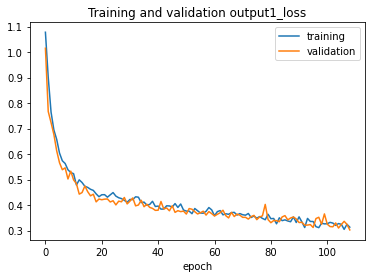

<Figure size 432x288 with 0 Axes>

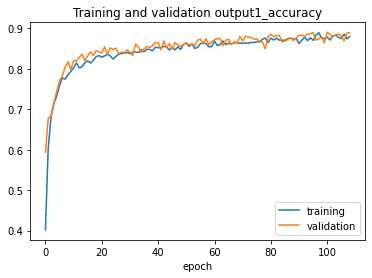

---------------------------------------------
GoogLeNet Dense output 1:
> Accuracy on train : 0.8741379380226135 	Loss on train: 0.32788699865341187
> Accuracy on test : 0.8725000023841858 	Loss on test: 0.36031386256217957
---------------------------------------------
> predicting test
---------------------------------------------
50/50 [==============================] - 32s 533ms/step


<Figure size 432x288 with 0 Axes>

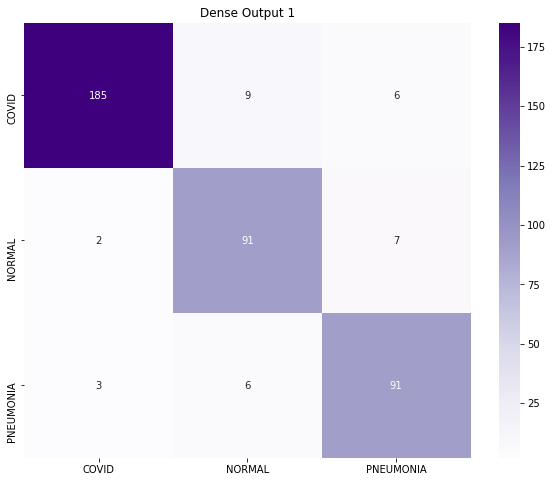

.............................................
> Correct Predictions: 367
> Wrong Predictions: 33
.............................................
              precision    recall  f1-score   support

       COVID       0.97      0.93      0.95       200
      NORMAL       0.86      0.91      0.88       100
   PNEUMONIA       0.88      0.91      0.89       100

    accuracy                           0.92       400
   macro avg       0.90      0.92      0.91       400
weighted avg       0.92      0.92      0.92       400



C:\Users\MCSP_Lab\AppData\Local\Temp/ipykernel_16480/2559713061.py:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n_correct = np.int(corr_pred[0][0] + corr_pred[1][1] + corr_pred[2][2])


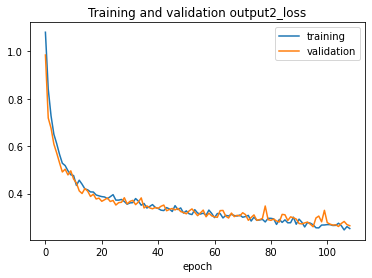

<Figure size 432x288 with 0 Axes>

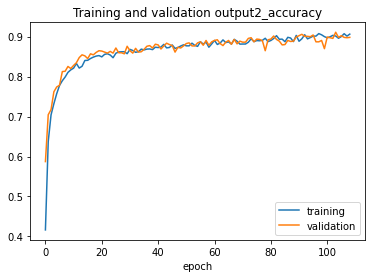

---------------------------------------------
GoogLeNet Dense output 2:
> Accuracy on train : 0.9038792848587036 	Loss on train: 0.2651093304157257
> Accuracy on test : 0.8999999761581421 	Loss on test: 0.283890962600708
---------------------------------------------
> predicting test
---------------------------------------------
50/50 [==============================] - 26s 529ms/step


<Figure size 432x288 with 0 Axes>

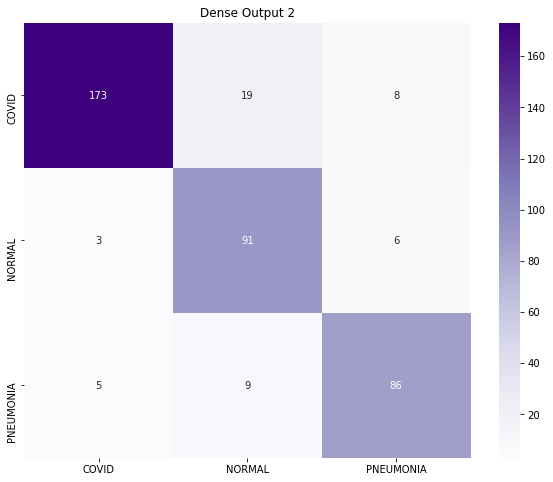

.............................................
> Correct Predictions: 350
> Wrong Predictions: 50
.............................................
              precision    recall  f1-score   support

       COVID       0.96      0.86      0.91       200
      NORMAL       0.76      0.91      0.83       100
   PNEUMONIA       0.86      0.86      0.86       100

    accuracy                           0.88       400
   macro avg       0.86      0.88      0.87       400
weighted avg       0.88      0.88      0.88       400



C:\Users\MCSP_Lab\AppData\Local\Temp/ipykernel_16480/2559713061.py:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n_correct = np.int(corr_pred[0][0] + corr_pred[1][1] + corr_pred[2][2])


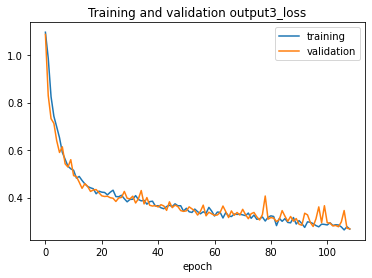

<Figure size 432x288 with 0 Axes>

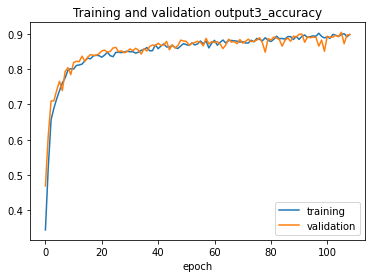

---------------------------------------------
GoogLeNet Dense output 3:
> Accuracy on train : 0.8935344815254211 	Loss on train: 0.2838849127292633
> Accuracy on test : 0.9175000190734863 	Loss on test: 0.23594413697719574
---------------------------------------------
> predicting test
---------------------------------------------
50/50 [==============================] - 26s 522ms/step


<Figure size 432x288 with 0 Axes>

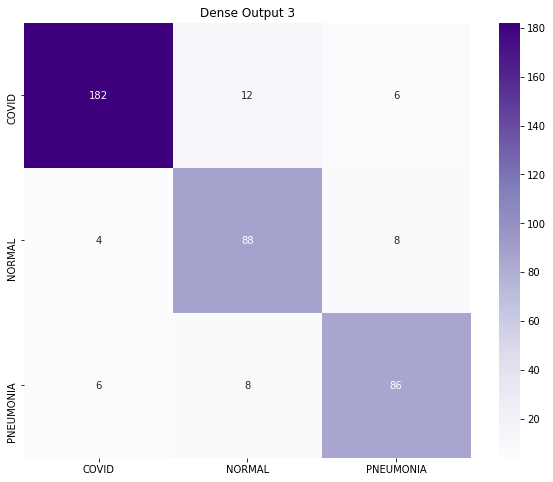

.............................................
> Correct Predictions: 356
> Wrong Predictions: 44
.............................................
              precision    recall  f1-score   support

       COVID       0.95      0.91      0.93       200
      NORMAL       0.81      0.88      0.85       100
   PNEUMONIA       0.86      0.86      0.86       100

    accuracy                           0.89       400
   macro avg       0.87      0.88      0.88       400
weighted avg       0.89      0.89      0.89       400



C:\Users\MCSP_Lab\AppData\Local\Temp/ipykernel_16480/2559713061.py:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n_correct = np.int(corr_pred[0][0] + corr_pred[1][1] + corr_pred[2][2])


In [114]:
model_summary(g_model, g_history, 'GoogLeNet')

## **DenseNet121 Results**

Best Epochs:  27
50/50 [==============================] - 26s 525ms/step - loss: 0.1468 - accuracy: 0.9475


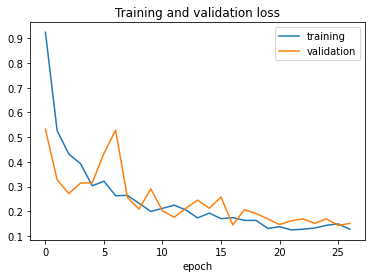

<Figure size 432x288 with 0 Axes>

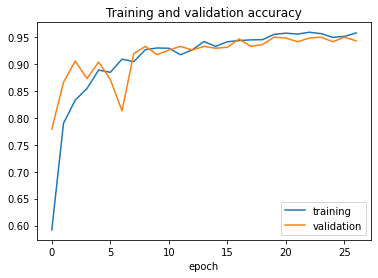

---------------------------------------------
DenseNet121
> Accuracy on train: 0.9568965435028076 	Loss on train: 0.12639445066452026
> Accuracy on test: 0.9474999904632568 	Loss on test: 0.14681197702884674
---------------------------------------------
> predicting test
---------------------------------------------
50/50 [==============================] - 28s 532ms/step


<Figure size 432x288 with 0 Axes>

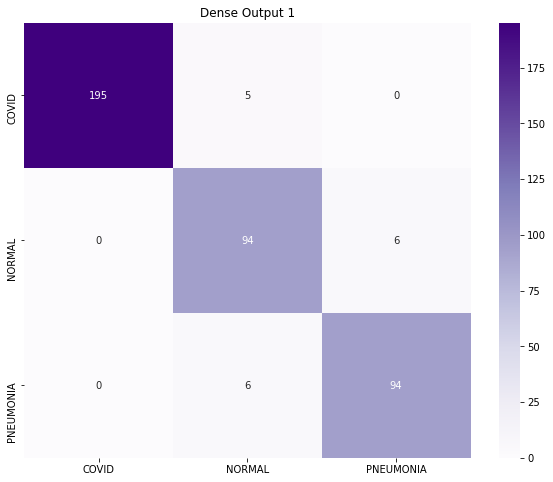

.............................................
> Correct Predictions: 383
> Wrong Predictions: 17
.............................................
              precision    recall  f1-score   support

       COVID       1.00      0.97      0.99       200
      NORMAL       0.90      0.94      0.92       100
   PNEUMONIA       0.94      0.94      0.94       100

    accuracy                           0.96       400
   macro avg       0.95      0.95      0.95       400
weighted avg       0.96      0.96      0.96       400



C:\Users\MCSP_Lab\AppData\Local\Temp/ipykernel_16480/2559713061.py:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n_correct = np.int(corr_pred[0][0] + corr_pred[1][1] + corr_pred[2][2])


In [115]:
model_summary(d_model, d_history, 'DenseNet121')

## Train DOLGNet

In [43]:
dolg_compiled_model = BuildModel('DOLGNet')
dolg_model, dolg_history = FitModel(dolg_compiled_model, 'DOLGNet')

Epoch 1/120
289/289 [==============================] - 104s 277ms/step - loss: 0.9233 - accuracy: 0.5819 - val_loss: 2.2546 - val_accuracy: 0.3476

Epoch 00001: val_loss improved from inf to 2.25459, saving model to DOLGNet_Weights.h5
Epoch 2/120
289/289 [==============================] - 78s 269ms/step - loss: 0.6379 - accuracy: 0.7349 - val_loss: 1.1719 - val_accuracy: 0.4726

Epoch 00002: val_loss improved from 2.25459 to 1.17191, saving model to DOLGNet_Weights.h5
Epoch 3/120
289/289 [==============================] - 78s 270ms/step - loss: 0.5512 - accuracy: 0.7875 - val_loss: 0.8927 - val_accuracy: 0.6027

Epoch 00003: val_loss improved from 1.17191 to 0.89274, saving model to DOLGNet_Weights.h5
Epoch 4/120
289/289 [==============================] - 78s 270ms/step - loss: 0.5578 - accuracy: 0.7866 - val_loss: 0.6836 - val_accuracy: 0.6884

Epoch 00004: val_loss improved from 0.89274 to 0.68365, saving model to DOLGNet_Weights.h5
Epoch 5/120
289/289 [==============================

## Hybrid Trans results

Best Epochs:  14
50/50 [==============================] - 26s 518ms/step - loss: 1.0265 - accuracy: 0.8475


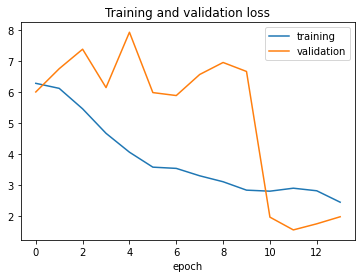

<Figure size 432x288 with 0 Axes>

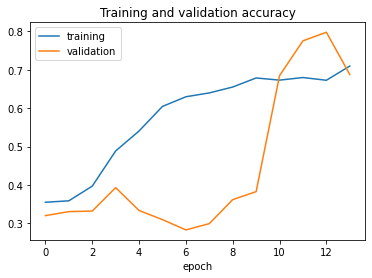

---------------------------------------------
HybridTransformer
> Accuracy on train: 0.6860029697418213 	Loss on train: 2.614490509033203
> Accuracy on test: 0.8475000262260437 	Loss on test: 1.026513695716858
---------------------------------------------
> predicting test
---------------------------------------------
50/50 [==============================] - 26s 524ms/step


ValueError: could not broadcast input array from shape (400,3) into shape (400,)

<Figure size 432x288 with 0 Axes>

In [107]:
model_summary(h_model, h_history, 'HybridTransformer')

## SwinTransformer Results

Best Epochs:  28
50/50 [==============================] - 21s 417ms/step - loss: 0.2666 - accuracy: 0.9075


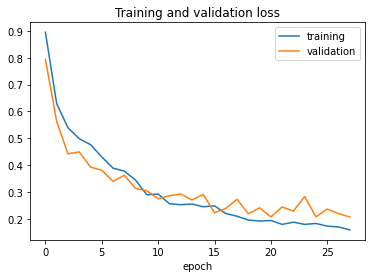

<Figure size 432x288 with 0 Axes>

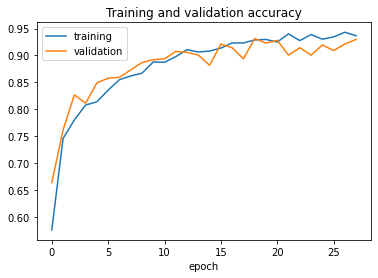

---------------------------------------------
SwinTransformer
> Accuracy on train: 0.9323275685310364 	Loss on train: 0.1835828572511673
> Accuracy on test: 0.9075000286102295 	Loss on test: 0.2666234076023102
---------------------------------------------
> predicting test
---------------------------------------------
50/50 [==============================] - 26s 401ms/step


<Figure size 432x288 with 0 Axes>

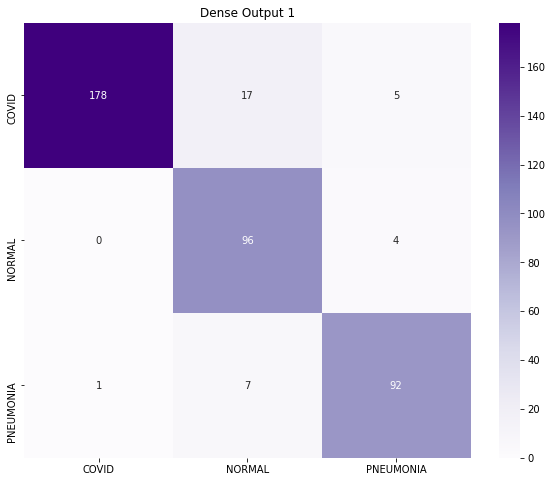

.............................................
> Correct Predictions: 366
> Wrong Predictions: 34
.............................................
              precision    recall  f1-score   support

       COVID       0.99      0.89      0.94       200
      NORMAL       0.80      0.96      0.87       100
   PNEUMONIA       0.91      0.92      0.92       100

    accuracy                           0.92       400
   macro avg       0.90      0.92      0.91       400
weighted avg       0.92      0.92      0.92       400



C:\Users\MCSP_Lab\AppData\Local\Temp/ipykernel_9608/2559713061.py:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n_correct = np.int(corr_pred[0][0] + corr_pred[1][1] + corr_pred[2][2])


In [35]:
model_summary(s_model, s_history, 'SwinTransformer')

## Inceptionnet Results

Best Epochs:  18
50/50 [==============================] - 22s 441ms/step - loss: 0.4927 - accuracy: 0.9175


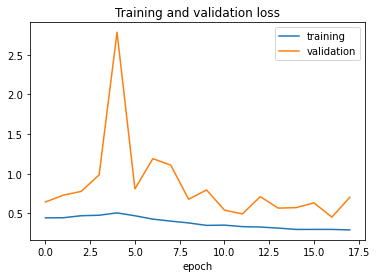

<Figure size 432x288 with 0 Axes>

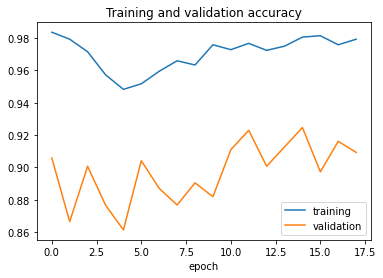

---------------------------------------------
InceptionNet
> Accuracy on train: 0.9784482717514038 	Loss on train: 0.28955191373825073
> Accuracy on test: 0.9175000190734863 	Loss on test: 0.4926796853542328
---------------------------------------------
> predicting test
---------------------------------------------
50/50 [==============================] - 23s 406ms/step


<Figure size 432x288 with 0 Axes>

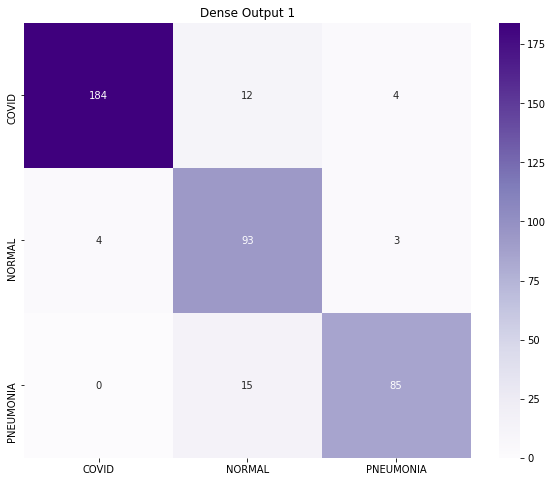

.............................................
> Correct Predictions: 362
> Wrong Predictions: 38
.............................................
              precision    recall  f1-score   support

       COVID       0.98      0.92      0.95       200
      NORMAL       0.78      0.93      0.85       100
   PNEUMONIA       0.92      0.85      0.89       100

    accuracy                           0.91       400
   macro avg       0.89      0.90      0.89       400
weighted avg       0.91      0.91      0.91       400



C:\Users\MCSP_Lab\AppData\Local\Temp/ipykernel_16480/2559713061.py:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n_correct = np.int(corr_pred[0][0] + corr_pred[1][1] + corr_pred[2][2])


In [145]:
model_summary(i_model, i_history, 'InceptionNet')

## DOLG Results

Best Epochs:  32
50/50 [==============================] - 24s 490ms/step - loss: 0.1705 - accuracy: 0.9500


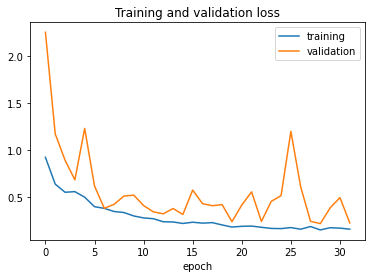

<Figure size 432x288 with 0 Axes>

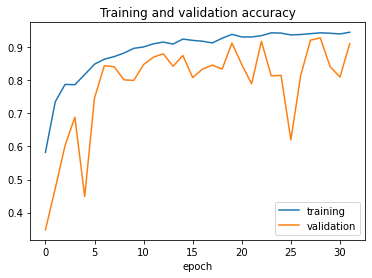

---------------------------------------------
DOLGNet
> Accuracy on train: 0.9534482955932617 	Loss on train: 0.13048508763313293
> Accuracy on test: 0.949999988079071 	Loss on test: 0.17053952813148499
---------------------------------------------
> predicting test
---------------------------------------------
50/50 [==============================] - 24s 414ms/step


<Figure size 432x288 with 0 Axes>

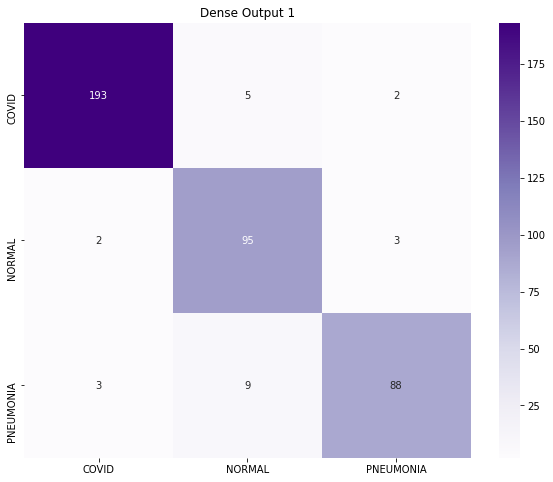

.............................................
> Correct Predictions: 376
> Wrong Predictions: 24
.............................................
              precision    recall  f1-score   support

       COVID       0.97      0.96      0.97       200
      NORMAL       0.87      0.95      0.91       100
   PNEUMONIA       0.95      0.88      0.91       100

    accuracy                           0.94       400
   macro avg       0.93      0.93      0.93       400
weighted avg       0.94      0.94      0.94       400



C:\Users\MCSP_Lab\AppData\Local\Temp/ipykernel_9608/2559713061.py:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n_correct = np.int(corr_pred[0][0] + corr_pred[1][1] + corr_pred[2][2])


In [44]:
model_summary(dolg_model, dolg_history, 'DOLGNet')

## **Saving Models**

In [ ]:
from IPython.display import FileLink

In [ ]:
g_model.save('GoogLeNet_model.h5')
FileLink(r'./GoogLeNet_model.h5')

In [ ]:
d_model.save('DenseNet121_model.h5')
FileLink(r'./DenseNet121_model.h5')

In [ ]:
s_model.save('SwinTransformer_model.h5')
FileLink(r'./SwinTransformer_model.h5')

In [ ]:
a=1
while a=1:
    b=a

## **Deployed model**

+ **Models**: DenseNet121
+ **Size**: 85.9 MB
+ **Build With**: React Native
+ **Supported Versions**: ANDROID, IOS, WEB

In [ ]:
from IPython.display import IFrame
IFrame(src='https://model-tester.web.app/covid_19', width='100%', height=1000)

# **tf_hybrid_efficientnet_swin_transformer_gradcam (balanced_5555)**

In [117]:
import os, random, cv2
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import tensorflow.keras.backend as K 
import tensorflow as tf; print(tf.__version__)
from tensorflow.keras import layers 
from tensorflow import keras 

import matplotlib.pyplot as plt
from numpy.random import rand 
import matplotlib.cm as cm
import numpy as np 

physical_devices = tf.config.list_physical_devices('GPU')
try: 
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    tf.config.optimizer.set_jit(True)
except: 
    pass

seed = 786
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

2.6.0


In [120]:
three_classes_covid_xray_balanced = '/Users/MCSP_Lab/Desktop/covidx-dataset/covidx-cxr2/datasets/train_covidx9a_balance_5555/'

In [51]:
epochs       = 15 
img_size     = 384
batch_size   = 2
class_number = 3
use_cut_mix  = True
#AUTOTUNE = tf.data.AUTOTUNE
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_set = keras.utils.image_dataset_from_directory(
    three_classes_covid_xray_balanced,
    validation_split=0.2,
    subset="training",
    seed=img_size,
    image_size=(img_size, img_size),
    batch_size=batch_size
)

val_set = keras.utils.image_dataset_from_directory(
    three_classes_covid_xray_balanced,
    validation_split=0.2,
    subset="validation",
    seed=img_size,
    image_size=(img_size, img_size),
    batch_size=batch_size
)

tcls_names, vcls_names = train_set.class_names , val_set.class_names
tcls_names, vcls_names 

AttributeError: module 'keras.utils' has no attribute 'image_dataset_from_directory'

(4, 384, 384, 3) (4,)


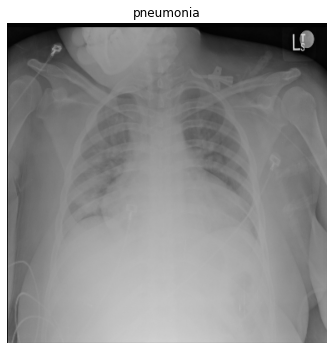

In [122]:
plt.figure(figsize=(20, 20))
for images, labels in train_set.take(1):
    print(images.shape, labels.shape)
    
    for i in range(1):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(tcls_names[labels[i]])
        plt.axis("off")

In [123]:
class MixUp(layers.Layer):
    '''Original implementation: https://www.kaggle.com/cdeotte/cutmix-and-mixup-on-gpu-tpu
    Adopted and modified: M.Innat.
    '''
    def __init__(self, num_classes, batch_size, mixup_prob=0.88, **kwargs):
        super().__init__(**kwargs)
        self.prob = mixup_prob 
        self.batch_size = batch_size
        self.num_classes = num_classes
    
    def call(self, batch_inputs, training=None):
        bs_images = batch_inputs[0] # ALL Image Samples 
        bs_labels = batch_inputs[1] # ALL Lable Samples 
        
        # Meta info 
        _, height, width, channel = bs_images.get_shape().as_list()
        mixup_images = []; mixup_labels = []
    
        for j in range(self.batch_size):
            # Choose Random Image to MixUp with
            k = tf.cast( tf.random.uniform([], 0, tf.cast(self.batch_size, tf.float32)), tf.int32)

            # Do MixUp with PROBABILITY Defined Above
            p = tf.cast( tf.random.uniform([], 0, 1) <= self.prob, tf.float32)

            # It's beta dist with alpha=1.0
            a = tf.random.uniform([], 0, 1)*p

            # Do MixUp 2 Images 
            img_x = bs_images[j]
            img_y = bs_images[k]
            mixup_images.append( (1-a) * img_x + a * img_y )

            # Do MixUp 2 Labels 
            if len(bs_labels.shape) == 1:
                lbs_x = tf.one_hot(bs_labels[j], self.num_classes)
                lbs_y = tf.one_hot(bs_labels[k], self.num_classes)
            else:
                lbs_x = bs_labels[j]
                lbs_y = bs_labels[k]
                
            lbs_x = tf.cast(lbs_x, tf.float32)
            lbs_y = tf.cast(lbs_y, tf.float32)
            mixup_labels.append( (1-a) * lbs_x + a * lbs_y )

        # Reshape 
        mixup_images = tf.reshape(tf.stack(mixup_images), (-1, height, width, channel))
        mixup_labels = tf.reshape(tf.stack(mixup_labels), (-1, self.num_classes))
        return [mixup_images, mixup_labels]

In [124]:
class CutMix(layers.Layer):
    '''Original implementation: https://www.kaggle.com/cdeotte/cutmix-and-mixup-on-gpu-tpu
    Adopted and modified: M.Innat.
    '''
    def __init__(self, num_classes, batch_size, cutmix_prob=0.88, **kwargs):
        super().__init__(**kwargs)
        self.prob = cutmix_prob 
        self.batch_size = batch_size
        self.num_classes = num_classes
        
    def call(self, batch_inputs, training=None):
        bs_images = batch_inputs[0] # ALL Image Samples 
        bs_labels = batch_inputs[1] # ALL Lable Samples 
        # Meta info 
        _, height, width, channel = bs_images.get_shape().as_list()
        img_size = height # TO DO: Support Non-Square Image 
        cutmix_images = []; cutmix_labels = []

        for j in range(self.batch_size):
            # Do CutMix with PROBABILITY Defined Above
            p = tf.cast( tf.random.uniform([],0, 1) <= self.prob, tf.int32)

            # Choose Random Image to CutMix with
            k = tf.cast( tf.random.uniform([], 0, self.batch_size), tf.int32)

            # Choose Random Location 
            x = tf.cast( tf.random.uniform([],0, img_size),tf.int32)
            y = tf.cast( tf.random.uniform([],0, img_size),tf.int32)

            # It's beta dist with alpha=1.0
            b = tf.random.uniform([], 0, 1) 

            w = tf.cast(img_size * tf.math.sqrt(1-b), tf.int32) * p
            ya = tf.math.maximum(0,   y-w//2)
            yb = tf.math.minimum(img_size, y+w//2)
            xa = tf.math.maximum(0,   x-w//2)
            xb = tf.math.minimum(img_size, x+w//2)

            # Do CutMix 
            one    = bs_images[j, ya:yb, 0:xa,        :]
            two    = bs_images[k, ya:yb, xa:xb,       :]
            three  = bs_images[j, ya:yb, xb:img_size, :]
            middle = tf.concat([one, two, three], axis=1)
            img    = tf.concat([bs_images[j, 0:ya, :, :],
                                middle,
                                bs_images[j, yb:img_size, :, :]], axis=0)
            cutmix_images.append(img)

            # MAKE CUTMIX LABEL
            a = tf.cast(w * w / img_size / img_size, tf.float32)
            if len(bs_labels.shape) == 1:
                lab1 = tf.one_hot(bs_labels[j], self.num_classes)
                lab2 = tf.one_hot(bs_labels[k], self.num_classes)
            else:
                lab1 = bs_labels[j]
                lab2 = bs_labels[k]

            cutmix_labels.append((1-a)*lab1 + a*lab2)

        # Reshape 
        cutmix_images = tf.reshape(tf.stack(cutmix_images), (-1, height, width, channel))
        cutmix_labels = tf.reshape(tf.stack(cutmix_labels), (-1, self.num_classes))
        return [cutmix_images, cutmix_labels]

In [125]:
class RandomMixUpCutMix(layers.Layer):
    def __init__(self, num_classes, batch_size, switch_prob=0.50, mixup_prob=1.0, cutmix_prob=1.0, **kwargs):
        super().__init__(**kwargs)
        self.mixup_prob = mixup_prob   # mixup probability
        self.cutmix_prob = cutmix_prob # cutmix probability
        self.switch_prob = switch_prob # probability of switching between mixup and cutmix 
        self.mixup  = CutMix(num_classes, batch_size=batch_size, cutmix_prob=cutmix_prob)
        self.cutmix = MixUp(num_classes, batch_size=batch_size, mixup_prob=mixup_prob)
        
    def call(self, batch_inputs, training=None):
        if training: 
            bs_images = batch_inputs[0] # ALL Image Samples 
            bs_labels = batch_inputs[1] # ALL Lable Samples 
            return tf.cond(
                tf.less(
                    tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32), 
                    tf.cast(self.switch_prob, tf.float32)),
                    lambda: self.mixup([bs_images, bs_labels]), lambda: self.cutmix([bs_images, bs_labels]))
        else:
            return batch_inputs

In [126]:
# for train set : augmentation 
keras_aug = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomZoom(.2, .3),
        layers.RandomRotation((0.2, 0.3), fill_mode="reflect")
        
    ]
)

train_ds = train_set.shuffle(10 * batch_size)
train_ds = train_ds.map(lambda x, y: (keras_aug(x), y), num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(lambda x, y: RandomMixUpCutMix(len(tcls_names), 
                                                       batch_size)([x, y], training=True), 
                        num_parallel_calls=AUTOTUNE)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

In [146]:
train_ds

<PrefetchDataset shapes: ((None, 384, 384, 3), (4, 3)), types: (tf.float32, tf.float32)>

(4, 384, 384, 3) (4, 3)


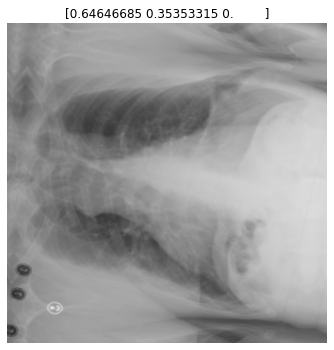

(4, 384, 384, 3) (4, 3)


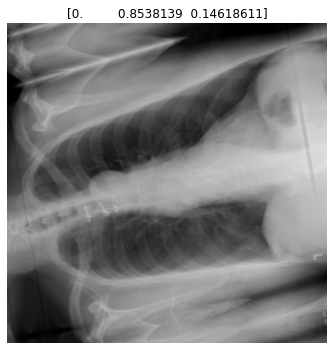

(4, 384, 384, 3) (4, 3)


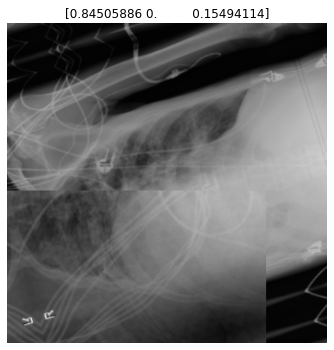

(4, 384, 384, 3) (4, 3)


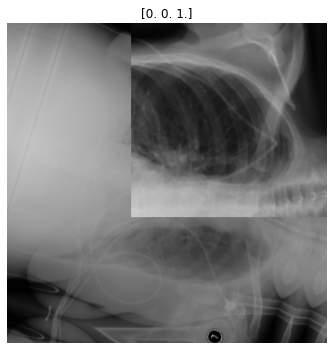

(4, 384, 384, 3) (4, 3)


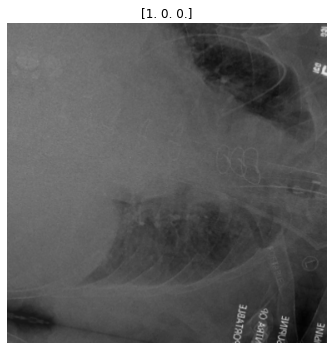

In [127]:
for images, labels in train_ds.take(5):
    print(images.shape, labels.shape)
    plt.figure(figsize=(20, 20))
    for i in range(1):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(labels[i].numpy())
        plt.axis("off")
    plt.show()

(4, 384, 384, 3) (4, 3)


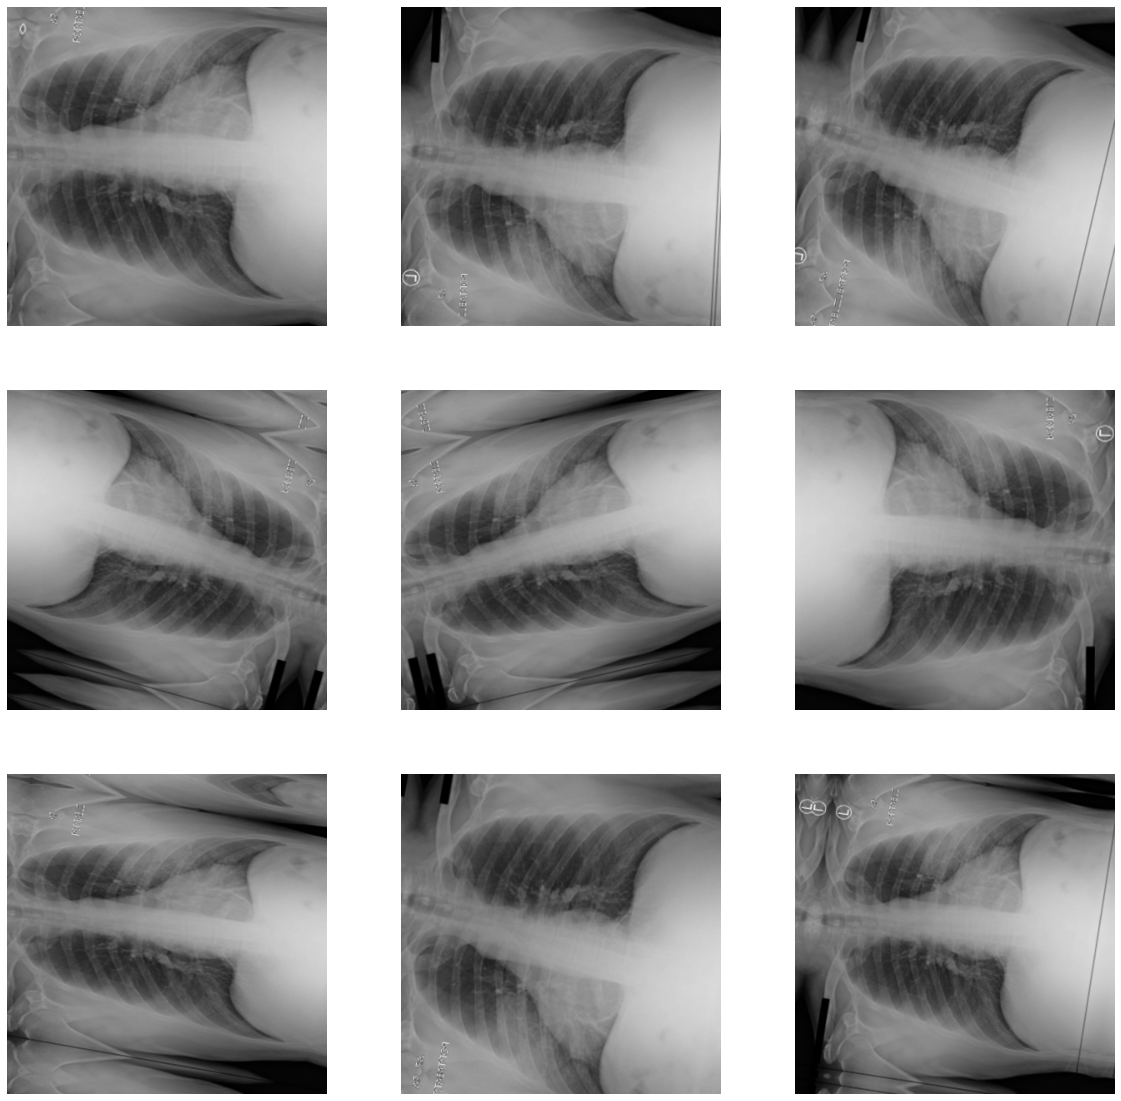

In [128]:
# for validation set : no augmentation 
def k_hot(x, y): 
    return x, tf.one_hot(y, class_number)

val_ds = val_set.map(k_hot) if use_cut_mix else val_ds
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

plt.figure(figsize=(20, 20))
for images, labels in val_ds.take(1):
    print(images.shape, labels.shape)
    for i in range(9):
        augmented_images = keras_aug(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [129]:
from tensorflow.keras import losses, optimizers , metrics
from tensorflow.keras import callbacks
from tensorflow_addons import optimizers as tfa_optimizers

rlr = callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.3, patience=2)
ckp = callbacks.ModelCheckpoint('model.h5', 
                                monitor="val_accuracy", 
                                verbose=1,
                                save_best_only=True, 
                                save_weights_only=True,
                                mode="max")

In [130]:
# compile and run 
if use_cut_mix:
    loss_fn = losses.CategoricalCrossentropy(label_smoothing = 0.01, from_logits=True)
else:
    loss_fn = losses.SparseCategoricalCrossentropy(from_logits=True) 

In [131]:
# compile and run
model.compile(
    loss=loss_fn,
    optimizer=tfa_optimizers.AdamW(learning_rate=1e-4, weight_decay=0.00001),
    metrics=['accuracy']
)

# ISSUE: ValueError: Unable to create dataset (name already exists)
# [ugly workaround!]
for i in range(len(model.weights)):
    model.weights[i]._handle_name = model.weights[i].name +  str(i)

In [132]:
# training 
history = model.fit(train_ds, 
                    epochs=epochs,
                    callbacks=[ckp, rlr], 
                    validation_data=val_ds, 
                    verbose=0)


Epoch 00001: val_accuracy improved from -inf to 0.81573, saving model to model.h5

Epoch 00002: val_accuracy did not improve from 0.81573


KeyboardInterrupt: 

In [ ]:
acc     = history.history['accuracy'] 
val_acc = history.history['val_accuracy'] 

loss     = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [101]:
def plot_stuff(inputs, features_a, features_b):
    plt.figure(figsize=(25, 25))
    
    plt.subplot(1, 3, 1)
    plt.axis('off')
    plt.imshow(tf.squeeze(inputs/255, axis=0))
    plt.title('Input')
    
    plt.subplot(1, 3, 2)
    plt.axis('off')
    plt.imshow(features_a)
    plt.title('CNN')
    
    plt.subplot(1, 3, 3)
    plt.axis('off')
    plt.imshow(features_b)
    plt.title('Hybrid-CNN-Transformer')
    plt.show()

# ref: https://keras.io/examples/vision/grad_cam/
def get_img_array(img):
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

# ref: https://keras.io/examples/vision/grad_cam/
def make_gradcam_heatmap(img_array, grad_model, pred_index=None):
    with tf.GradientTape(persistent=True) as tape:
        preds, base_top, swin_top = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
        
    grads = tape.gradient(class_channel, base_top)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    base_top = base_top[0]
    heatmap_a = base_top @ pooled_grads[..., tf.newaxis]
    heatmap_a = tf.squeeze(heatmap_a)
    heatmap_a = tf.maximum(heatmap_a, 0) / tf.math.reduce_max(heatmap_a)
    heatmap_a = heatmap_a.numpy()
    
    grads = tape.gradient(class_channel, swin_top)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    swin_top = swin_top[0]
    heatmap_b = swin_top @ pooled_grads[..., tf.newaxis]
    heatmap_b = tf.squeeze(heatmap_b)
    heatmap_b = tf.maximum(heatmap_b, 0) / tf.math.reduce_max(heatmap_b)
    heatmap_b = heatmap_b.numpy()
    return heatmap_a, heatmap_b

(4, 384, 384, 3)
(12, 12) 1.0 0.0
(12, 12) 1.0 0.0


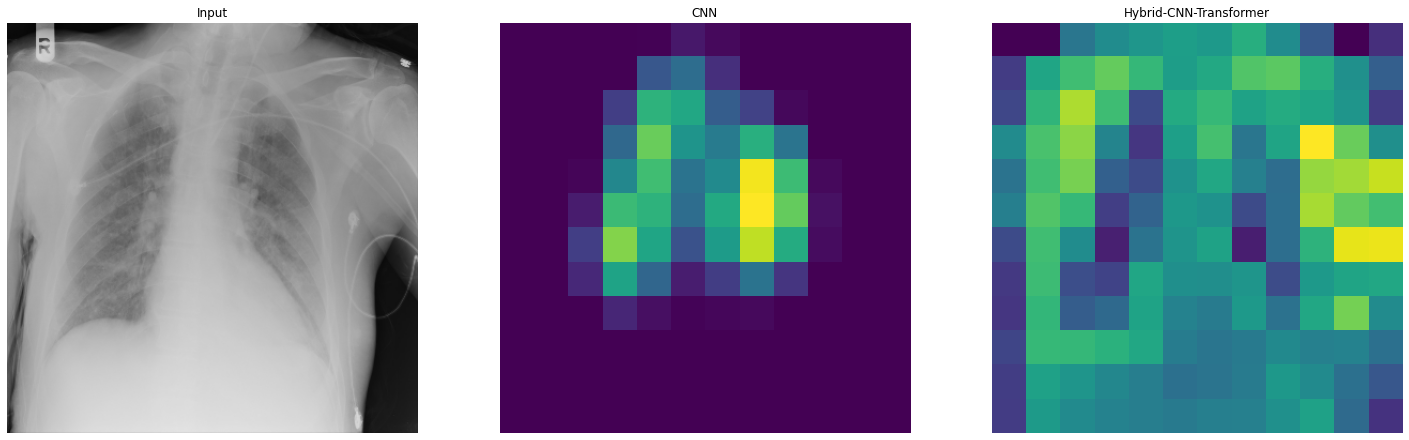

(12, 12) 1.0 0.0
(12, 12) 1.0 0.0


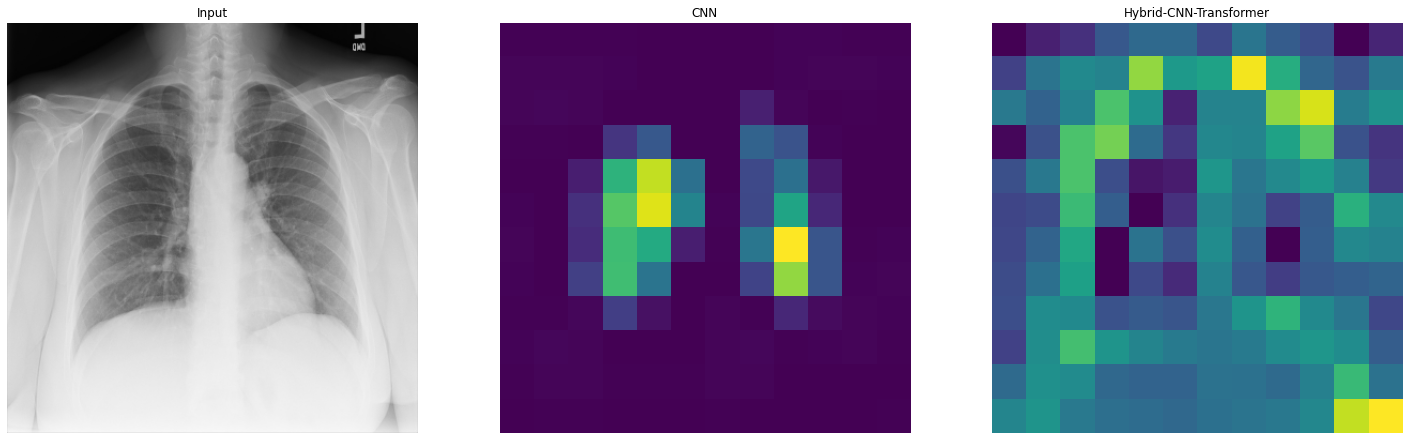

(12, 12) 1.0 0.0
(12, 12) 1.0 0.0


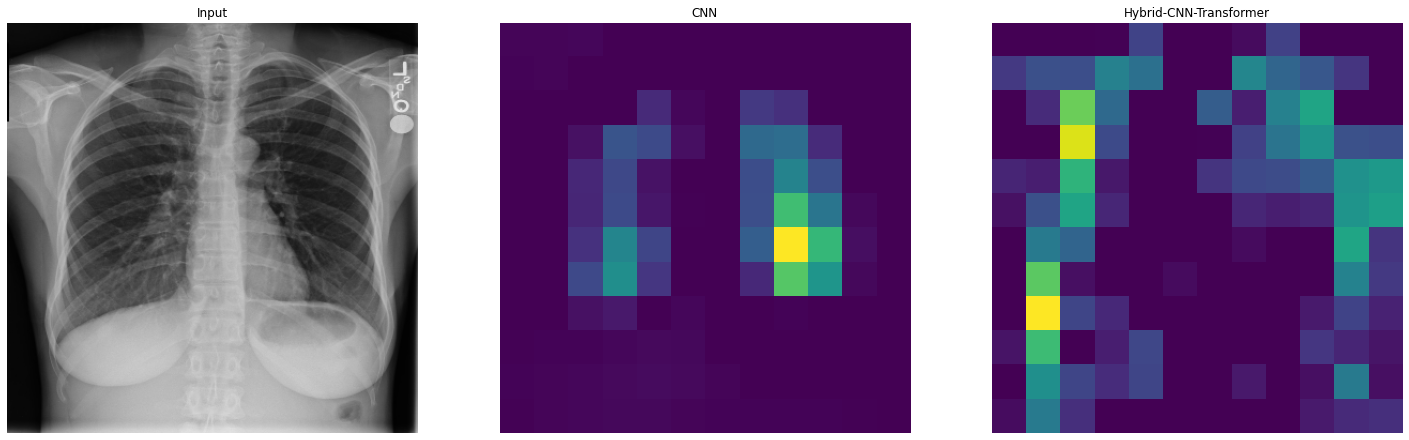

(12, 12) 1.0 0.0
(12, 12) 1.0 0.0


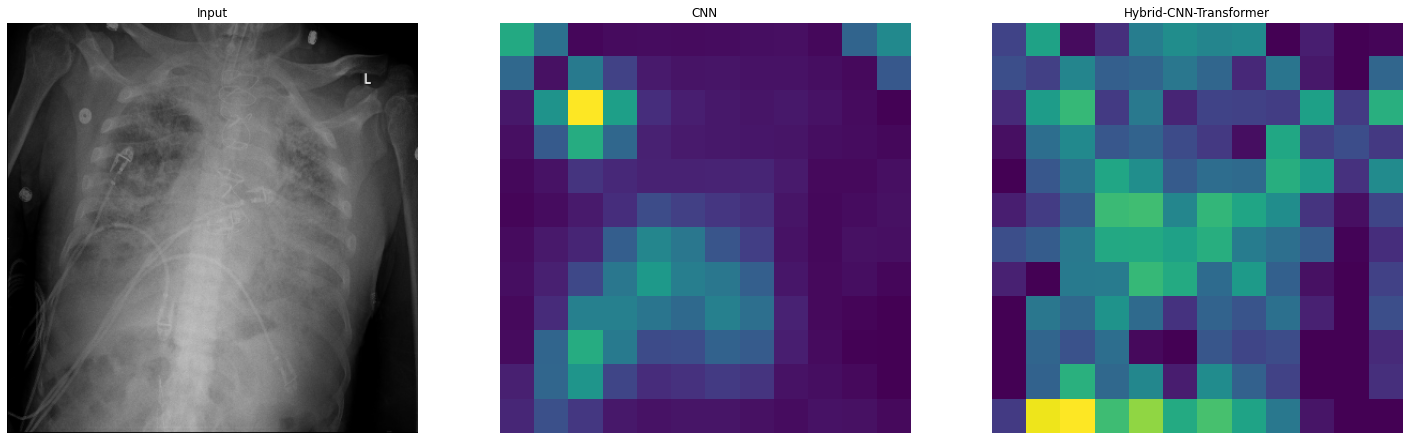

In [102]:
# load save weight
model.load_weights('./model.h5')

# Prepare image
img_arrays = next(iter(val_ds))[0]; print(img_arrays.shape)

# plot utils
for img_array in img_arrays:
    # Generate class activation heatmap
    img_array = get_img_array(img_array)
    cnn_heatmap, swin_heatmap = make_gradcam_heatmap(img_array, model) 
    print(cnn_heatmap.shape, cnn_heatmap.max(), cnn_heatmap.min())
    print(swin_heatmap.shape, swin_heatmap.max(), swin_heatmap.min())
    
    # Display heatmap
    plot_stuff(img_array, cnn_heatmap, swin_heatmap)

In [103]:
# ref: https://keras.io/examples/vision/grad_cam/
def save_and_display_gradcam(img, 
                             heatmap, 
                             target=None, 
                             pred=None,
                             cam_path="cam.jpg",  
                             alpha=0.6, 
                             plot=None):
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet") 

    # Use RGB values of the colormap
    jet_colors  = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[0], img.shape[1]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = img + jet_heatmap * alpha
    superimposed_img = keras.utils.array_to_img(superimposed_img)
    return superimposed_img

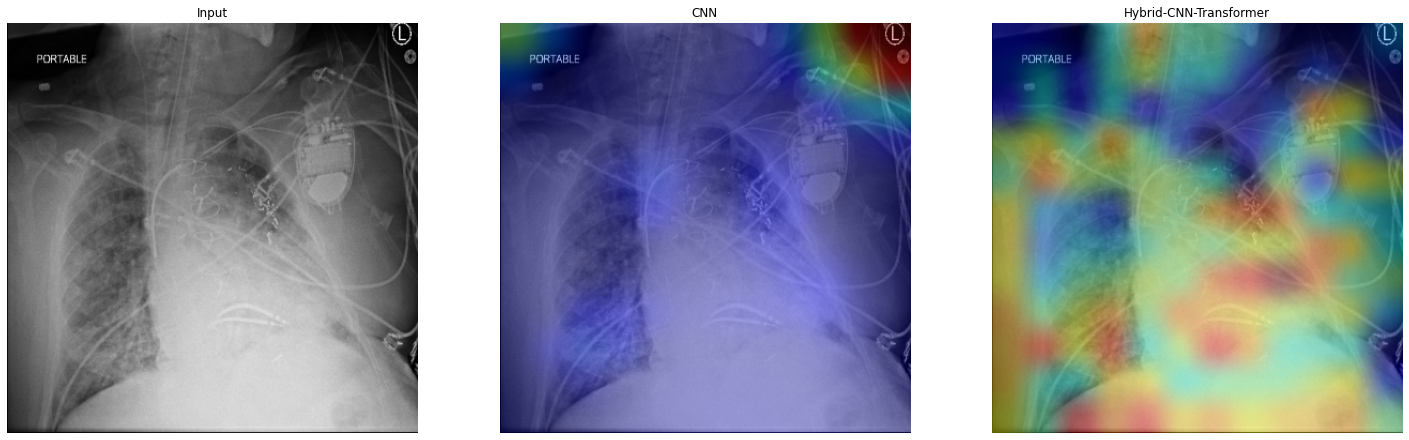

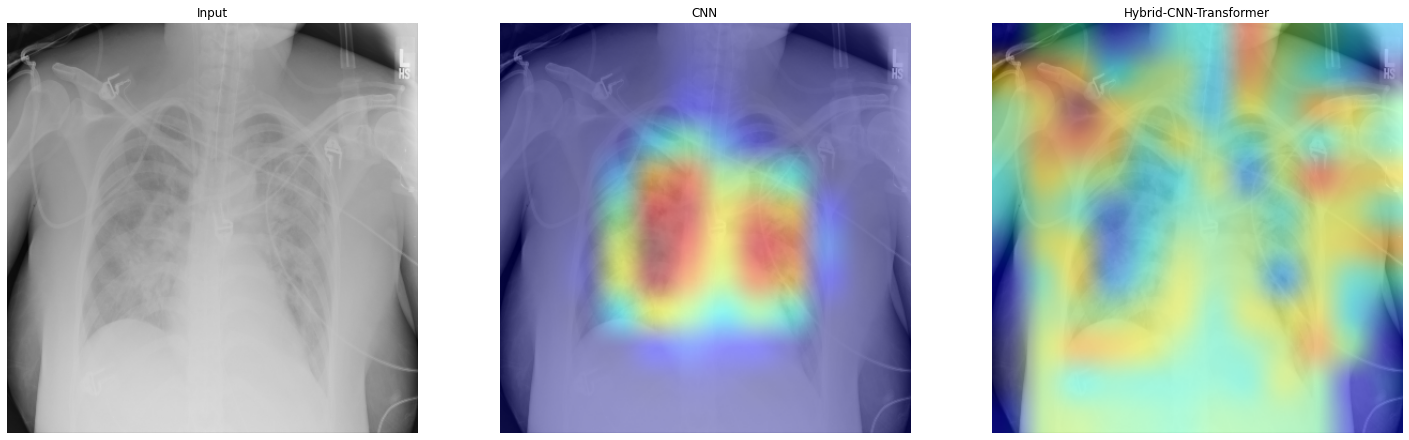

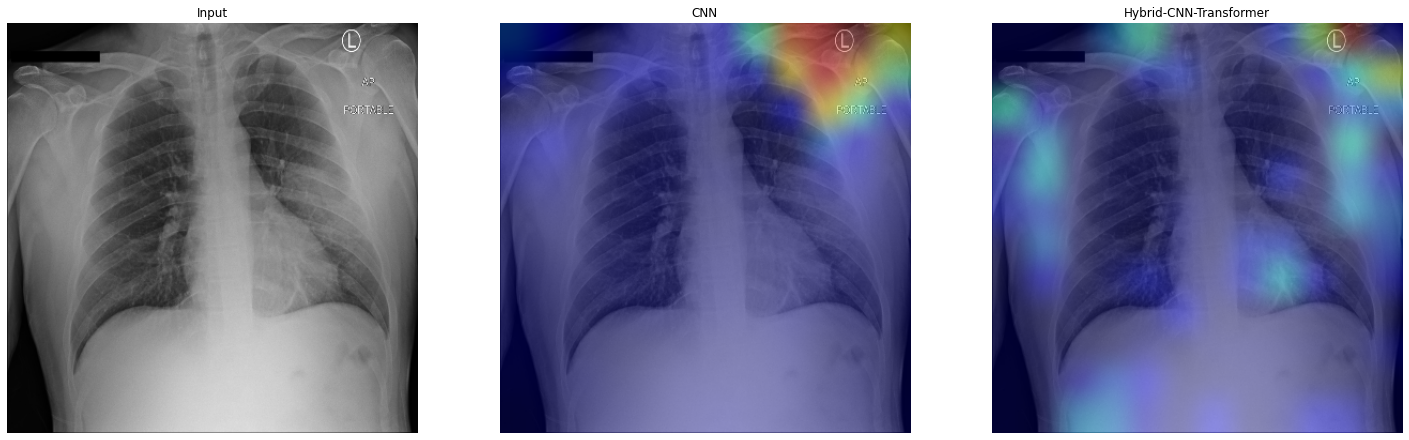

In [104]:
samples, labels = next(iter(val_ds))

for sample, label in zip(samples, labels):
    # preparing 
    img_array = sample[tf.newaxis, ...] 
    
    # get heatmaps 
    heatmap_a, heatmap_b = make_gradcam_heatmap(img_array, model)
    
    # overaly heatmap and input sample 
    overaly_a = save_and_display_gradcam(sample, heatmap_a)
    overlay_b = save_and_display_gradcam(sample, heatmap_b)
    
    # ploting stuff 
    plot_stuff(img_array, overaly_a, overlay_b)